<a href="https://colab.research.google.com/github/EveZhang19/AGT/blob/main/updated_highR0_pop500_TC75_of_ABM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Utils

In [ ]:
!pip install mesa
!pip install networkx
!pip install bokeh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.2 MB/s 
     |████████████████████████████████| 66 kB 4.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time, enum, math, random
import numpy as np
import pandas as pd
import pylab as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector

import networkx as nx
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
import seaborn as sns
from scipy.stats import sem 

In [ ]:
#import community as community_louvain
import community.community_louvain as community_louvain
from sklearn.cluster import SpectralClustering
from scipy.sparse import csr_matrix
from itertools import count
from networkx.utils import not_implemented_for, py_random_state, BinaryHeap
from networkx.algorithms.community.community_utils import is_partition
import heapq

In [ ]:
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, GeoJSONDataSource, ColorBar, HoverTool, Legend, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.models.glyphs import Line
from bokeh.palettes import Category10, Viridis
output_notebook()
import panel as pn
import panel.widgets as pnw
pn.extension()

##Agent Model

In [ ]:
#SEIR
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    EXPOSED = 1
    INFECTED = 2
    REMOVED = 3

In [ ]:
def exp_rand(lam):
  if lam <= 0:
    return -1
  U = random.uniform(0.0, 1.0)
  return (-1.0 / lam) * math.log(U)

In [ ]:
class MyAgent(Agent):
    """ An agent in an epidemic model."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        #self.age = int(self.random.normalvariate(20,40))
        self.unique_id = unique_id
        self.state = State.SUSCEPTIBLE 
        self.infection_time = 0
        self.infection_prob = exp_rand(model.infect_lam)
        self.node_degree = model.G.degree(unique_id-1)
        self.infection_counts = 0

    def move(self):
        """Move the agent"""

        possible_steps = [
            node
            for node in self.model.grid.get_neighbors(self.pos, include_center=False)
            if self.model.grid.is_cell_empty(node)
        ]
        if len(possible_steps) > 0:
            new_position = self.random.choice(possible_steps)                 
            self.model.grid.move_agent(self, new_position)

    def status(self):
        """Check infection status"""
        if self.state == State.EXPOSED:                 
            t = self.model.schedule.time-self.exposed_time
            if t >= self.model.incubation_time:          
                self.state = State.INFECTED
                self.infection_time = self.model.schedule.time

        
        if self.state == State.INFECTED:     
            #drate = self.model.death_rate
            #alive = np.random.choice([0,1], p=[drate,1-drate])
            #if alive == 0:
            #    self.model.schedule.remove(self)            
            t = self.model.schedule.time-self.infection_time
            if t >= self.recovery_time:          
                self.state = State.REMOVED
            #print (self.model.schedule.time,self.recovery_time,t)

    def contact(self):
        """Find close contacts and infect"""
        self.infection_counts = 0
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbors = [
            agent
            for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
            if agent.state is State.SUSCEPTIBLE
        ]
        if self.state == State.INFECTED:
          for a in susceptible_neighbors:
              #if self.infection_prob < model.ptrans:
              if self.random.random() < self.infection_prob:
                  a.state = State.EXPOSED
                  a.exposed_time = model.schedule.time
                  a.recovery_time = model.get_recovery_time()
                  self.infection_counts += 1
                                  
    def step(self):
        self.status()
        self.move()
        self.contact()

    def toJSON(self):        
        d = self.unique_id
        return json.dumps(d, default=lambda o: o.__dict__, 
            sort_keys=True, indent=4)



## Infection Model


n = 500 #Number of nodes

m = 5 #Number of edges to attach from a new node to existing nodes

G = nx.barabasi_albert_graph(n, m)

In [ ]:
class NetworkInfectionModel(Model):
    """A model for infection spread."""
    
    def __init__(self, N=10, initial_outbreak_size = 5, data_G = nx.erdos_renyi_graph(n=10, p=0.012),#ptrans=0.5, 
                 avg_node_degree=3, #progression_period=3, progression_sd=2, #death_rate=0.0193, 
                 recovery_days=7, recovery_sd=4, incubation_time = 7, infect_lam = 6):
        
        #self.num_agents = N
        self.num_nodes = N  
        
        
        self.initial_outbreak_size = initial_outbreak_size
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd
        #self.ptrans = ptrans
        #self.death_rate = death_rate
        self.incubation_time = incubation_time
        self.infect_lam = infect_lam
        
        #define the network
        #self.G = nx.erdos_renyi_graph(n=self.num_nodes, p=prob)
        self.G = data_G
        self.grid = NetworkGrid(self.G)
        
        self.schedule = RandomActivation(self)
        self.running = True
        #self.dead_agents = []
        
        init_infect = random.sample(range(1,self.num_nodes), self.initial_outbreak_size)
        init_infect.sort()
        iter_key = 0

        # Create agents
        for i, node in enumerate(self.G.nodes()):
            a = MyAgent(i+1, self)
            self.schedule.add(a)
            #add agent
            self.grid.place_agent(a, node)

            #make some agents infected at start
            #infected = np.random.choice([0,1], p=[0.99,0.01])
            if iter_key < self.initial_outbreak_size:
              if i == init_infect[iter_key]:
                a.state = State.INFECTED
                a.recovery_time = self.get_recovery_time()
                iter_key += 1

        self.datacollector = DataCollector(
            agent_reporters={"State": "state"})
        self.datacollector_infection_counts = DataCollector(
            agent_reporters={"Secondary_transmission": "infection_counts", "p":"infection_prob", "node_degree":"node_degree"})

    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))

    def remove(id, self):
        #self.schedule.agents[id].state = State.REMOVED
        for agent in self.schedule.agents:
            if agent.unique_id == id:
              agent.state = State.REMOVED

    def step(self):
        self.datacollector.collect(self)
        self.datacollector_infection_counts.collect(self)
        self.schedule.step()
        
        

In [ ]:
model = NetworkInfectionModel(300)
model.step()
model

In [ ]:
def get_column_data(model):
    #pivot the model dataframe to get states count at each step
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    labels = ['Susceptible','Exposed','Infected','Removed']
    X.columns = labels[:len(X.columns)]
    return X
    
def plot_states(model,ax):    
    steps = model.schedule.steps
    X = get_column_data(model)
    X.plot(ax=ax,lw=4,alpha=0.8)
    return f

def get_secondary_transmission(model):
    #pivot the dataframe to get the number of secondary transmission that each agent caused
    ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
    icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
    return icc_cc

##Graph Partition

In [ ]:
def random_groups(G, size):
    """Generates random groups for testing."""
    nodes = list(G.nodes())
    np.random.shuffle(nodes)

    groups = [[]]
    for i in range(len(nodes)):
        if len(groups[-1]) == size:
            groups.append([])
            
        groups[-1].append(nodes[i])
    
    return groups

  
def cluster_groups(clusters, size):
    """Generates groups for testing from clusters"""
    clusters.sort(key=len, reverse=True)
    
    clustered_nodes = []
    for c in range(len(clusters)):
        clustered_nodes = clustered_nodes + clusters[c]
    
    groups = [[]]
    for i in range(len(clustered_nodes)):
        if len(groups[-1]) == size:
            groups.append([])
            
        groups[-1].append(clustered_nodes[i])
        
    return groups

def modularity_min(G, weight='weight'):
    '''Modularity minimization clustering.Returns list of clusters.'''
    if weight is None:
        vertex_cluster = community_louvain.best_partition(G)
    else:
        vertex_cluster = community_louvain.best_partition(G, weight=weight)
            
    clusters = []
        
    for c in range(np.max(list(vertex_cluster.values()))+1):
        clusters.append([])
    
    for v in vertex_cluster:
        c = vertex_cluster[v]
        clusters[c].append(v)
    
    return clusters

def topol_greedy_group(G, group_size, weight='weight'):
    '''
        Greedily groups two sets of nodes by maximizing 
        the total weight inside groups at each step.
    '''
    group_assign = {}
    groups = []
    
    #Groups initialized as singletons
    for v in G.nodes():
        group_assign[v] = len(groups)
        groups.append([v])

    #Each edge is a candidate merge
    #weights stores cross group weights for pairs
    weights = {}
    heap = []
    for e in G.edges:
        if weight is None:
            w = 1.
        else:
            w = G.edges[e]['weight']
        
        idx_i = min(group_assign[e[0]], group_assign[e[1]])
        idx_j = max(group_assign[e[0]], group_assign[e[1]])
        
        if idx_i not in weights:
            weights[idx_i] = {}
            
        if idx_j not in weights:
            weights[idx_j] = {}
        
        weights[idx_i][idx_j] = w
        weights[idx_j][idx_i] = w
        
        heap.append((-w, (idx_i,idx_j)))
    
    heapq.heapify(heap)
    
    while len(heap) > 0:
        item = heapq.heappop(heap)
        idx_i = item[1][0]
        idx_j = item[1][1]

        if len(groups[idx_i]) > 0 and len(groups[idx_j]) > 0:
            if len(groups[idx_i])+len(groups[idx_j]) <= group_size:
                
    #Picks next merge and creates new group
                idx_new = len(groups)
                weights[idx_new] = {}
                groups.append(groups[idx_i]+groups[idx_j])
                
                groups[idx_i] = []
                groups[idx_j] = []
                
    #Updates weights for new group
                for c in weights[idx_i]:
                    if c != idx_j and len(groups[c]) > 0:
                        w = weights[idx_i][c]
                        
                        if c in weights[idx_j]:
                            w = w + weights[idx_j][c]
                        
                        weights[idx_new][c] = w
                        weights[c][idx_new] = w
                        
                        heapq.heappush(heap, (-w, (c, idx_new)))
                        
                for c in weights[idx_j]:
                    if c != idx_i and len(groups[c]) > 0 and c not in weights[idx_new]:
                        w = weights[idx_j][c]
                        
                        if c in weights[idx_i]:
                            w = w + weights[idx_i][c]
                            
                        weights[idx_new][c] = w
                        weights[c][idx_new] = w
                        
                        heapq.heappush(heap, (-w, (c, idx_new)))
                        
    non_empty_groups = []   
    for g in groups:
        if len(g) > 0:
            non_empty_groups.append(g)
            
    return cluster_groups(non_empty_groups, group_size)


def topol_greedy_group_degree(G, group_size, weight='weight'):
    '''
        Greedily groups two sets of nodes by maximizing 
        the total node degree inside groups at each step.
    '''
    group_assign = {}
    groups = []
    
    #Groups initialized as singletons
    for v in G.nodes():
        group_assign[v] = len(groups)
        groups.append([v])

    #Each edge is a candidate merge
    #weights stores cross group weights for pairs
    weights = {}
    heap = []
    for e in G.edges:
        if weight is None:
            w = 1.
        else:
            w = G.edges[e]['weight']
        
        idx_i = min(group_assign[e[0]], group_assign[e[1]])
        idx_j = max(group_assign[e[0]], group_assign[e[1]])
        
        if idx_i not in weights:
            weights[idx_i] = {}
            
        if idx_j not in weights:
            weights[idx_j] = {}
        
        weights[idx_i][idx_j] = w
        weights[idx_j][idx_i] = w
        
        heap.append((-w, (idx_i,idx_j)))
    
    heapq.heapify(heap)
    
    while len(heap) > 0:
        item = heapq.heappop(heap)
        idx_i = item[1][0]
        idx_j = item[1][1]

        if len(groups[idx_i]) > 0 and len(groups[idx_j]) > 0:
            if len(groups[idx_i])+len(groups[idx_j]) <= group_size:
                
		#Picks next merge and creates new group
                idx_new = len(groups)
                weights[idx_new] = {}
                groups.append(groups[idx_i]+groups[idx_j])
                
                groups[idx_i] = []
                groups[idx_j] = []
                
		#Updates weights for new group
                for c in weights[idx_i]:
                    if c != idx_j and len(groups[c]) > 0:
                        w = weights[idx_i][c]
                        
                        if c in weights[idx_j]:
                            w = w + weights[idx_j][c]
                        
                        weights[idx_new][c] = w
                        weights[c][idx_new] = w
                        
                        heapq.heappush(heap, (-w, (c, idx_new)))
                        
                for c in weights[idx_j]:
                    if c != idx_i and len(groups[c]) > 0 and c not in weights[idx_new]:
                        w = weights[idx_j][c]
                        
                        if c in weights[idx_i]:
                            w = w + weights[idx_i][c]
                            
                        weights[idx_new][c] = w
                        weights[c][idx_new] = w
                        
                        heapq.heappush(heap, (-w, (c, idx_new)))
                        
    non_empty_groups = []   
    for g in groups:
        if len(g) > 0:
            non_empty_groups.append(g)
            
    return cluster_groups(non_empty_groups, group_size)

In [ ]:
def max_intra_commu_greedy(G, group_size, weight='weight'):
    '''
        Greedily groups two sets of nodes by maximizing 
        the intra-community edges inside groups at each step.
    '''
    group_assign = {}
    groups = []
    
    #Groups initialized as singletons
    for v in G.nodes():
        group_assign[v] = len(groups)
        groups.append([v])

    #Each edge is a candidate merge
    #weights stores cross group weights for pairs
    weights = {}
    heap = []
    for e in G.edges:
        if weight is None:
            w = 1.
        else:
            w = G.edges[e]['weight']
        
        idx_i = min(group_assign[e[0]], group_assign[e[1]])
        idx_j = max(group_assign[e[0]], group_assign[e[1]])
        
        if idx_i not in weights:
            weights[idx_i] = {}
            
        if idx_j not in weights:
            weights[idx_j] = {}
        
        weights[idx_i][idx_j] = w
        weights[idx_j][idx_i] = w
        
        heap.append((-w, (idx_i,idx_j)))
    
    heapq.heapify(heap)
    
    while len(heap) > 0:
        item = heapq.heappop(heap)
        idx_i = item[1][0]
        idx_j = item[1][1]

        if len(groups[idx_i]) > 0 and len(groups[idx_j]) > 0:
            if len(groups[idx_i])+len(groups[idx_j]) <= group_size:
                
		#Picks next merge and creates new group
                idx_new = len(groups)
                weights[idx_new] = {}
                groups.append(groups[idx_i]+groups[idx_j])
                
                groups[idx_i] = []
                groups[idx_j] = []
                
		#Updates weights for new group
                for c in weights[idx_i]:
                    if c != idx_j and len(groups[c]) > 0:
                        w = G.subgraph([c, idx_i]).number_of_edges()
                        
                        if c in weights[idx_j]:
                            w = G.subgraph([c, idx_i, idx_j]).number_of_edges()
                        
                        weights[idx_new][c] = w
                        weights[c][idx_new] = w
                        heapq.heappush(heap, (-w, (c, idx_new)))
                        
                for c in weights[idx_j]:
                    if c != idx_i and len(groups[c]) > 0 and c not in weights[idx_new]:
                        w = G.subgraph([c, idx_j]).number_of_edges()
                        
                        if c in weights[idx_i]:
                            w = G.subgraph([c, idx_i, idx_j]).number_of_edges()
                            
                        weights[idx_new][c] = w
                        weights[c][idx_new] = w
                        heapq.heappush(heap, (-w, (c, idx_new)))

    non_empty_groups = []   
    for g in groups:
        if len(g) > 0:
            non_empty_groups.append(g)
            
    return cluster_groups(non_empty_groups, group_size)

In [ ]:
def evaluate_two_level_group_testing(infec_matrix, groups, capacity):
    '''
    '''
    n_tests =  capacity * np.ones(infec_matrix.shape[1])
    total = 0
    #TODO:sorted groups!!!
    
    for g in range(capacity):
        sz = len(groups[g])
        total = total+sz
        
        group = []
        for v in groups[g]:
            v = int(v)
            if v < infec_matrix.shape[0]:
                group.append(v)
        
        ind_test = infec_matrix[group].sum(axis=0)
        ind_test[ind_test > 0] = 1
        n_tests = n_tests + sz * ind_test
        
    return n_tests / total

# BA

In [ ]:
G = nx.barabasi_albert_graph(n=500, m=3)

print("# of nodes: ", G.number_of_nodes())
print("Average degree: ", 2*G.number_of_edges()/G.number_of_nodes())

# of nodes:  500
Average degree:  5.964


In [ ]:
def network_gen():
  G = nx.barabasi_albert_graph(n=500, m=3)
  return G

##Testing Strategy _0

In [ ]:
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, avg_node_degree=6, data_G = network_gen())
for i in range(steps):
    model.step()
print (time.time()-st)
#agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:30])


2.5643470287323
      Susceptible  Exposed  Infected  Removed
Step                                         
0             495        0         5        0
1             489        6         5        0
2             487        8         5        0
3             487        8         5        0
4             486        9         5        0
5             483       12         5        0
6             482       13         5        0
7             481       14         4        1
8             475       14        10        1
9             465       22        10        3
10            462       25        10        3
11            461       25         9        5
12            453       30        12        5
13            447       35        12        6
14            441       40        10        9
15            431       44        16        9
16            416       49        26        9
17            385       77        26       12
18            370       91        23       16
19            344 

In [ ]:
print("max_outbreak_size: ", get_column_data(model).Infected.max())
print("number_of_uninfected:",get_column_data(model).Susceptible.min())

max_outbreak_size:  108
number_of_uninfected: 41


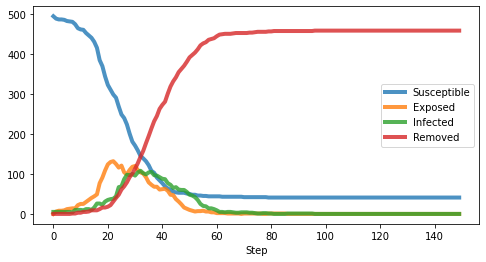

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
15                           32           47  0.393819
5                            20           32  0.277784
13                           17           27  0.298744
18                           16           46  0.192350
36                           13           16  0.138349
2                            12           49  0.104290
60                            9           17  0.403168
33                            9           13  0.207759
11                            9           14  0.454479
28                            9           16  0.243937
37                            8           12  0.230922
12                            7           27  0.154240
119                           7            9  0.204917
19                            6           20  0.179294
62                            5            9  0.572513
175                           5            6  0.863688
42                            5           12  0.390181
97                            5            7  0.881451
73                            5           11  0.163307
108                           4            7  0.133681

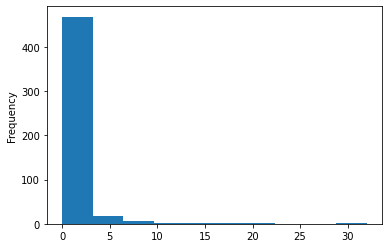

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

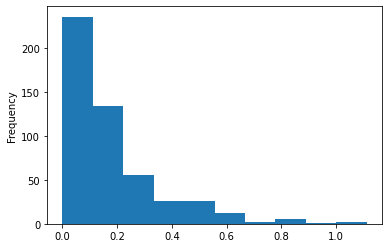

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _1

In [ ]:
#model set_up for strategy 1
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    ind = random.sample(range(1,pop+1), pop)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0

    if np.mod(pop, capacity) != 0:
        null_tail = [0] * (capacity - np.mod(pop, capacity))
        finish_flag = int(np.ceil(pop/capacity))
        ind.extend(null_tail)
        t_order = np.array(ind).reshape(finish_flag, capacity)
    else:
      finish_flag = int(pop/capacity)
      t_order = np.array(ind).reshape(finish_flag, capacity)
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            if test_key < finish_flag:
                temp = model.datacollector.get_agent_vars_dataframe()
                temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
                infection_matrix = csr_matrix(temp.values)
                for v in t_order[test_key]:
                    if v == 0:
                        test_key = 0
                        break
                    n_tests += 1
                    if infection_matrix[v-1, i] == 2:
                        model.schedule.agents[v-1].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v,i))) 
                    if infection_matrix[v-1, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v-1].exposed_time) > 4:
                            model.schedule.agents[v-1].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v,i)))
                test_key += 1
                if test_key == finish_flag:
                    test_key = 0
                
            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()

    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      12.464863              165        10350                  9   
1      12.452885                2        10350                  5   
2      14.360556              175        10350                 14   
3      12.474554              123        10350                 10   
4      12.670977              128        10350                 10   
..           ...              ...          ...                ...   
95     14.333455               42        10350                  5   
96     12.686282              227        10350                 20   
97     12.466334               47        10350                  5   
98     12.684323              200        10350                 33   
99     12.588588              124        10350                 12   

    max_2_trans  num_of_S  
0            20       297  
1             2       491  
2            26       284  
3            11       353  
4            18       343  
..          ...       ...  
95            9       440  
96           61       233  
97            7       443  
98           34       250  
99           15       347  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  12.83428254365921 0.0615991033917461
Average_found_positives:  134.15 6.701068435840526
Average_total_tests:  10350.0 0.0
Average_max_outbreak_size:  12.64 0.6267633710040204
Average_max_2_trans: 23.33 1.3644146263974428
Average_number_of_uninfected: 336.45 8.080896227423283


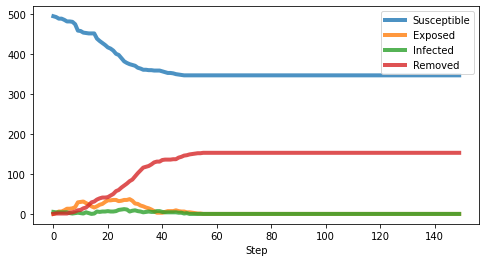

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


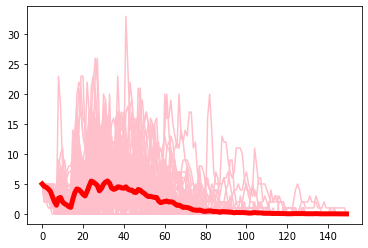

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)

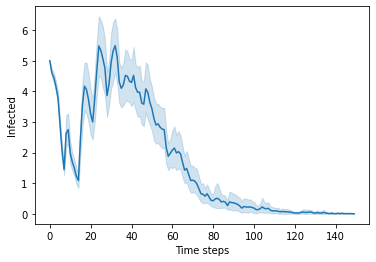

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_1 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
10                           15           34  0.064901
5                            15          108  0.187916
27                           14           25  0.131784
41                            7           16  0.072971
187                           6           10  0.402560
31                            5            9  0.328738
290                           5            9  0.149403
38                            5           14  0.305563
39                            5           24  0.217748
82                            5            7  0.184852
84                            5           11  0.075591
6                             5           38  0.105695
40                            3           21  0.209321
354                           3            6  0.147693
67                            3            9  0.165569
35                            3            7  0.704172
339                           3            5  0.510387
42                            2            7  0.210810
47                            2           11  0.066570
318                           2            4  0.343921

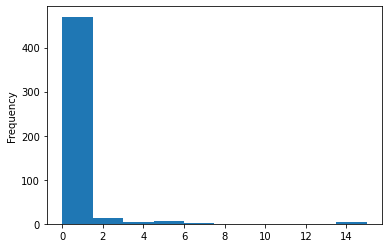

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

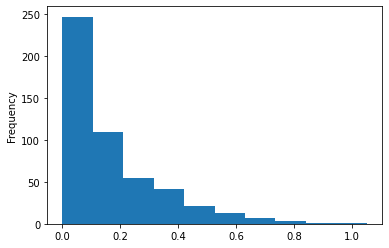

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _2

In [ ]:
#model set_up for strategy 2
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = random_groups(model.G, group_size)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0

      
    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      12.814976              289         1661                 29   
1      12.696299              187         1499                 13   
2      12.771320              216         1554                 20   
3      12.751569              213         1547                 16   
4      12.598993              271         1606                 26   
..           ...              ...          ...                ...   
95     12.677472              152         1381                 13   
96     12.809389              176         1510                  9   
97     12.759040              229         1604                 20   
98     12.918645               90         1291                  7   
99     12.802297              223         1597                 15   

    max_2_trans  num_of_S  
0            44       194  
1            37       301  
2            21       263  
3            29       268  
4            49       208  
..          ...       ...  
95           18       332  
96           13       305  
97           21       244  
98           16       402  
99           32       251  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  13.05750218629837 0.062444587130856
Average_found_positives:  198.56 7.214706081219376
Average_total_tests:  1506.84 20.294905167494026
Average_max_outbreak_size:  16.31 0.7745568951590217
Average_max_2_trans: 25.86 1.3964616179849165
Average_number_of_uninfected: 281.92 7.807813750055489


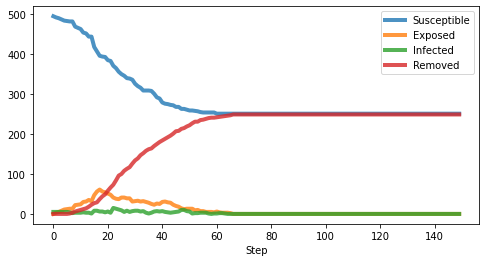

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


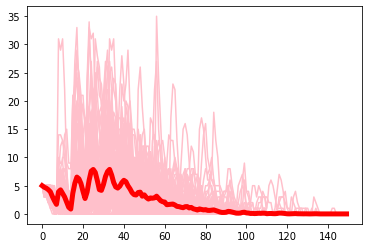

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


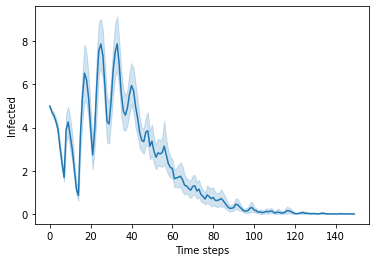

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_2 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
24                           32           38  0.476055
8                            14           25  0.265735
28                           10           23  0.351443
105                           9           14  0.253006
115                           9           12  0.335588
123                           8           10  0.484999
2                             7           34  0.132021
18                            7           31  0.066900
5                             6           25  0.178408
16                            6           18  0.304581
20                            6           30  0.089350
53                            5           11  0.245710
6                             5           36  0.093923
301                           4            5  0.310835
223                           4            5  0.491913
41                            4           14  0.160550
112                           4            7  0.328179
146                           4            7  0.285070
130                           4           10  0.598628
134                           4            5  0.491321

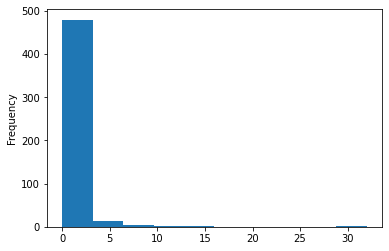

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

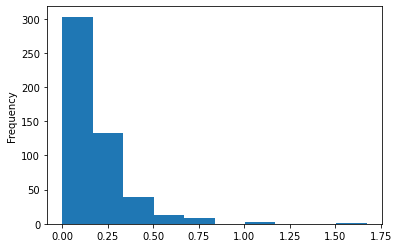

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _3

In [ ]:
#model set_up for strategy 3
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    random.shuffle(rand_groups)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      13.190289              165         1567                  8   
1      12.828851              199         1581                 12   
2      13.149002              202         1539                 24   
3      14.833852                5          886                  5   
4      13.268624              258         1580                 45   
..           ...              ...          ...                ...   
95     13.437593              124         1355                  9   
96     12.923785              229         1536                 17   
97     15.054607              250         1676                 21   
98     13.315143              194         1563                 17   
99     12.839449              170         1517                 10   

    max_2_trans  num_of_S  
0            19       321  
1            15       279  
2            40       274  
3             5       490  
4            83       219  
..          ...       ...  
95           24       361  
96           17       247  
97           22       230  
98           28       276  
99           13       317  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  13.394124119281768 0.061536533705157215
Average_found_positives:  202.5 7.450137277563781
Average_total_tests:  1544.57 21.891275209613305
Average_max_outbreak_size:  17.75 0.8742529278293449
Average_max_2_trans: 25.91 1.5738452556998381
Average_number_of_uninfected: 274.31 8.160321530108202


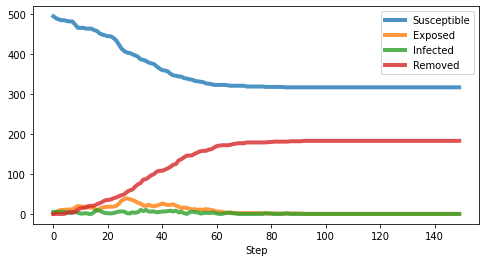

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


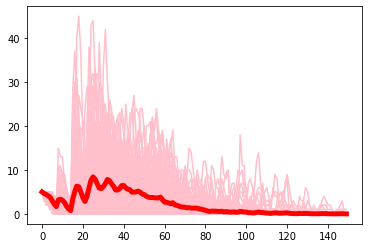

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


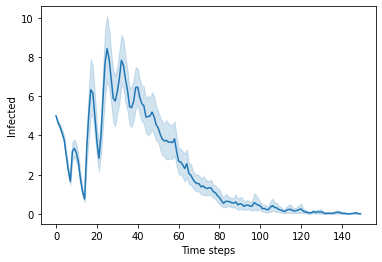

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_3 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
6                            13           63  0.096814
9                            11           27  0.175539
42                            9           11  0.134930
34                            8           17  0.205377
22                            7           14  0.160311
8                             7           85  0.043717
11                            5           37  0.038161
63                            5            8  0.369608
44                            5            7  0.519786
107                           4            6  0.224508
165                           4            6  0.189439
47                            4           14  0.135912
317                           3            5  0.489927
377                           3            4  1.115271
430                           3            4  0.438975
55                            3           11  0.149197
180                           3            4  0.113570
92                            3           12  0.153167
81                            3            9  0.484400
19                            3           14  0.116643

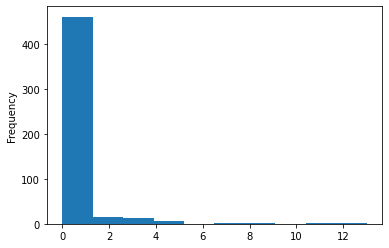

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

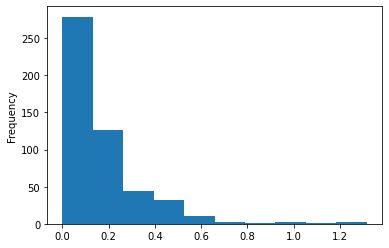

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _4

In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)
            else:
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      17.167832              236         1972                 12   
1      15.067868              252         1774                 20   
2      14.951427              148         1437                  7   
3      13.545799               17          946                  5   
4      13.979718               18          956                  5   
..           ...              ...          ...                ...   
95     15.802238              287         1982                 30   
96     14.937740              205         1577                 23   
97     15.008369              149         1537                 13   
98     13.735713               15          926                  5   
99     14.034904               11          935                  5   

    max_2_trans  num_of_S  
0            26       249  
1            40       218  
2            16       331  
3             5       480  
4             4       480  
..          ...       ...  
95           39       177  
96           51       277  
97           54       328  
98            7       482  
99            2       486  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  15.262521984577178 0.09009155870481786
Average_found_positives:  178.62 8.441513340316858
Average_total_tests:  1583.71 33.78695371610382
Average_max_outbreak_size:  15.58 0.7978734362052794
Average_max_2_trans: 27.31 1.7091964560144994
Average_number_of_uninfected: 303.01 9.207457396978372


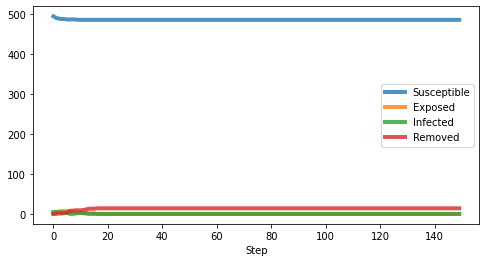

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


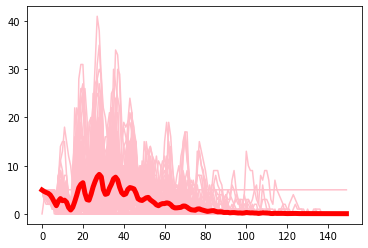

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


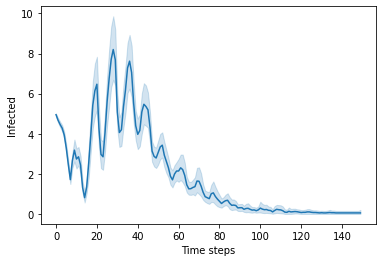

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_4 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
257                           2            4  0.238161
449                           2            4  0.422654
416                           2            3  0.092016
73                            1            8  0.063056
493                           1            3  0.080346
145                           1            4  0.079407
338                           0            3  0.022065
337                           0            3  0.058909
339                           0            3  0.054009
330                           0            3  0.276860
336                           0            4  0.012623
335                           0            6  0.179427
340                           0            3  0.092187
334                           0            4  0.020938
333                           0            3  0.044759
341                           0            3  0.165395
332                           0            4  0.216847
331                           0            4  0.183324
1                             0           78  0.145328
328                           0            3  0.177927

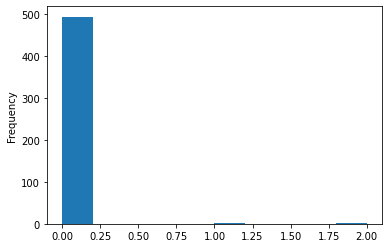

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

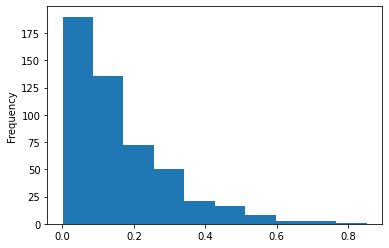

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(493, 10), (379, 11), (341, 12), (6, 12), (117, 15)]

In [ ]:
group_df

Group  Degree  Intra_C  \
19  [213, 228, 397, 175, 434, 354, 109, 139, 171, ...      48        7   
15    [454, 39, 46, 82, 209, 273, 400, 100, 150, 342]      47        7   
35    [380, 258, 53, 64, 480, 262, 275, 430, 339, 48]      60        7   
26  [182, 107, 210, 152, 343, 414, 365, 119, 206, ...      50        8   
14    [160, 418, 22, 29, 79, 255, 331, 479, 186, 292]      59        7   
43  [237, 470, 320, 467, 416, 220, 250, 486, 334, ...      43        8   
8   [349, 355, 457, 174, 192, 363, 499, 429, 252, ...      40        9   
37      [394, 332, 70, 71, 272, 56, 97, 315, 93, 120]      55        8   
47   [247, 452, 425, 84, 226, 263, 387, 372, 91, 313]      43        8   
48  [314, 134, 197, 390, 413, 373, 69, 296, 377, 388]      41        8   
13   [114, 77, 111, 212, 295, 76, 101, 140, 239, 106]      52        7   
12  [157, 123, 383, 169, 147, 151, 459, 455, 325, ...      45        7   
18   [108, 257, 223, 231, 218, 443, 351, 73, 75, 135]      53        8   
45  [153, 382, 437, 495, 487, 469, 367, 409, 438, ...      37        7   
24     [485, 446, 85, 132, 58, 113, 254, 35, 36, 261]      61        7   
39     [184, 221, 330, 471, 142, 128, 7, 11, 347, 50]      77        7   
27    [154, 44, 81, 431, 412, 279, 403, 474, 215, 26]      59        7   
41  [395, 43, 200, 407, 225, 285, 399, 369, 393, 476]      45        7   
29  [463, 168, 233, 178, 424, 321, 386, 497, 360, ...      42        7   
32      [465, 55, 270, 95, 8, 15, 420, 466, 232, 281]      92        6   
40   [118, 381, 305, 344, 348, 353, 440, 267, 24, 37]      54        7   
11    [201, 103, 67, 92, 185, 89, 141, 445, 161, 145]      55        6   
28  [30, 442, 364, 307, 308, 137, 165, 176, 291, 494]      51        7   
36  [124, 491, 199, 246, 436, 338, 125, 163, 244, ...      44        7   
21  [378, 253, 322, 441, 216, 359, 183, 293, 240, ...      40        7   
38   [274, 74, 94, 284, 211, 227, 311, 329, 404, 266]      42        6   
42   [88, 449, 401, 60, 158, 477, 115, 189, 410, 194]      46        6   
22   [202, 310, 241, 19, 187, 312, 196, 251, 59, 230]      43        6   
25     [104, 14, 68, 496, 384, 45, 57, 300, 294, 170]      53        6   
16  [181, 260, 86, 259, 278, 411, 117, 340, 366, 167]      42        6   
23         [5, 2, 4, 316, 352, 374, 166, 13, 16, 375]     158       11   
5    [271, 298, 358, 72, 102, 306, 318, 346, 62, 105]      61        9   
10   [195, 276, 327, 126, 20, 33, 356, 389, 488, 127]      86       10   
31      [148, 203, 376, 475, 217, 319, 31, 3, 6, 405]     152        9   
0     [98, 208, 144, 54, 78, 224, 130, 190, 317, 406]      53       10   
9       [350, 473, 481, 87, 12, 9, 10, 138, 235, 370]     116       11   
33       [204, 28, 65, 426, 47, 90, 408, 391, 61, 80]      78       10   
30    [249, 238, 444, 282, 447, 198, 368, 25, 18, 21]      80        9   
34     [428, 450, 498, 489, 193, 0, 1, 458, 402, 422]     115       10   
3      [248, 336, 417, 32, 38, 264, 290, 337, 41, 66]      63       10   
20  [268, 492, 287, 309, 345, 162, 180, 179, 191, ...      50        7   
17  [205, 99, 214, 229, 328, 136, 419, 435, 129, 143]      57        8   
49  [392, 17, 173, 398, 415, 423, 483, 472, 155, 245]      46        8   
44   [432, 460, 484, 286, 49, 83, 433, 482, 121, 242]      45        8   
4   [269, 396, 361, 96, 146, 324, 493, 468, 116, 122]      45        9   
7   [326, 462, 456, 110, 112, 335, 341, 379, 149, ...      43        9   
46      [288, 177, 23, 27, 439, 42, 323, 478, 51, 63]      66        9   
1   [133, 236, 283, 34, 156, 164, 297, 385, 159, 243]      52        9   
6    [277, 427, 303, 40, 52, 333, 464, 362, 280, 289]      50        9   
2   [207, 222, 265, 188, 234, 299, 371, 453, 131, ...      47        9   

       order  record  flag  
19  0.000003      18     1  
15  0.000003      18     1  
35  0.000002      18     1  
26  0.000002      18     1  
14  0.000002      18     1  
43  0.000002      18     1  
8   0.000004      17     0  
37  0.000004      17     0  
47  0.000004

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
257                           2            4  0.238161
449                           2            4  0.422654
416                           2            3  0.092016
73                            1            8  0.063056
493                           1            3  0.080346
145                           1            4  0.079407
338                           0            3  0.022065
337                           0            3  0.058909
339                           0            3  0.054009
330                           0            3  0.276860
336                           0            4  0.012623
335                           0            6  0.179427
340                           0            3  0.092187
334                           0            4  0.020938
333                           0            3  0.044759
341                           0            3  0.165395
332                           0            4  0.216847
331                           0            4  0.183324
1                             0           78  0.145328
328                           0            3  0.177927

##Testing Strategy_4_high_2


In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            else:
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)              
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      16.099576               40         1015                  6   
1      15.103594              158         1315                 25   
2      14.240243                7          906                  5   
3      16.814857              126         1290                  9   
4      14.753827               82         1191                  6   
..           ...              ...          ...                ...   
95     14.453781               67         1114                  5   
96     14.264986               22          955                  5   
97     15.339963              167         1436                  6   
98     15.115061              119         1293                 14   
99     15.547038              156         1272                 13   

    max_2_trans  num_of_S  
0            14       448  
1            19       280  
2             3       487  
3            13       354  
4            16       407  
..          ...       ...  
95           10       423  
96            8       473  
97           18       307  
98           16       349  
99           29       309  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  15.370853316783904 0.08354175935706193
Average_found_positives:  119.17 7.036370951109397
Average_total_tests:  1252.84 21.62877208299588
Average_max_outbreak_size:  13.17 0.88100665563475
Average_max_2_trans: 18.36 1.2203261693481624
Average_number_of_uninfected: 350.1 9.353684522230484


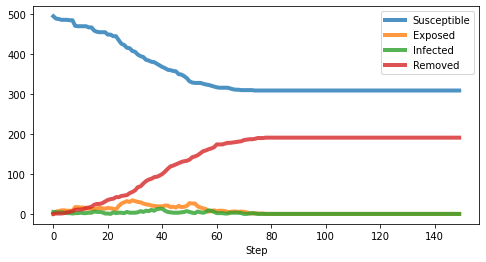

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


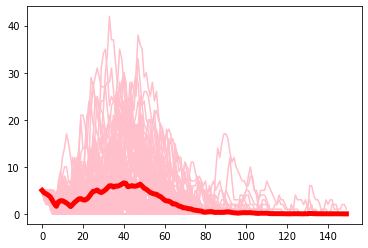

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


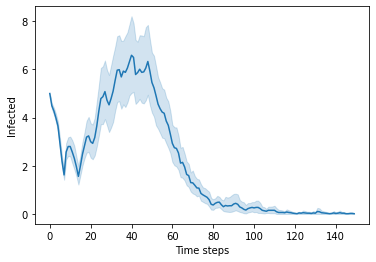

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_5 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
7                            29           38  0.315809
37                           14           19  0.253471
71                           10           12  1.341078
52                            8           10  0.392758
56                            6            8  0.573079
33                            6           12  0.499711
64                            5           15  0.086239
196                           4            5  0.538971
471                           4            4  0.418678
150                           4            5  0.480619
77                            4           11  0.276764
175                           4            7  0.247764
48                            3            9  0.498492
57                            3           10  0.272429
32                            3           10  0.497552
38                            3            7  0.495023
65                            3            7  0.296035
200                           3            7  0.475389
73                            3            9  0.238009
50                            3           12  0.172367

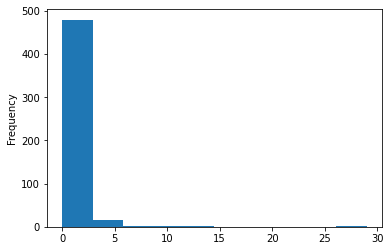

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

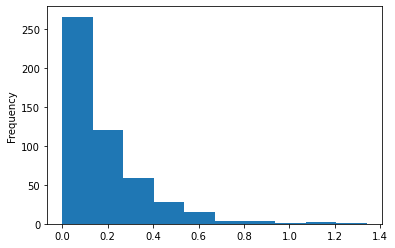

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(159, 71), (305, 73), (160, 74), (334, 74), (177, 77)]

In [ ]:
group_df

Group  Degree  Intra_C  \
22  [456, 291, 493, 191, 245, 318, 79, 103, 287, 299]      55        8   
39    [72, 495, 223, 268, 201, 145, 11, 18, 259, 315]      78        8   
36   [69, 209, 384, 443, 142, 216, 455, 273, 80, 108]      53        8   
2     [81, 360, 452, 284, 414, 115, 240, 260, 50, 63]      55        9   
16  [54, 462, 276, 118, 265, 469, 416, 199, 226, 135]      45        6   
30    [344, 249, 295, 388, 385, 23, 30, 355, 90, 325]      59        9   
37   [457, 187, 373, 397, 212, 76, 86, 467, 235, 433]      60        8   
27    [202, 55, 84, 496, 442, 104, 326, 439, 342, 68]      56        8   
5      [149, 361, 227, 35, 56, 185, 274, 391, 17, 94]      61        9   
41   [312, 319, 345, 171, 33, 62, 339, 430, 412, 332]      51        6   
38   [489, 221, 85, 121, 470, 302, 389, 466, 234, 53]      51        6   
14      [279, 478, 207, 186, 10, 8, 9, 451, 407, 170]     140        9   
34   [164, 210, 418, 136, 311, 471, 417, 73, 99, 432]      44        7   
32    [107, 359, 82, 200, 282, 183, 15, 61, 367, 289]      62        6   
15     [278, 155, 250, 215, 29, 91, 458, 236, 74, 21]      69        7   
28     [307, 498, 290, 41, 42, 484, 349, 43, 78, 485]      58        6   
11  [261, 340, 402, 232, 446, 422, 101, 146, 425, ...      44        9   
49  [480, 447, 141, 372, 459, 482, 348, 356, 374, ...      39        7   
6     [154, 492, 241, 28, 34, 173, 453, 275, 98, 125]      55        9   
48  [112, 369, 472, 405, 87, 130, 371, 419, 494, 203]      43        8   
20  [426, 161, 211, 214, 283, 248, 337, 343, 71, 106]      57        9   
46  [229, 298, 479, 449, 231, 476, 300, 398, 491, ...      39        6   
13   [465, 404, 233, 281, 450, 217, 31, 49, 434, 243]      51        6   
35  [421, 423, 277, 253, 123, 126, 438, 296, 378, 26]      49        7   
33     [363, 329, 140, 3, 13, 394, 321, 336, 97, 152]      77        8   
8   [194, 396, 242, 156, 179, 258, 244, 255, 264, ...      51        9   
17      [167, 406, 46, 52, 481, 305, 40, 51, 57, 420]      56        7   
18   [473, 48, 174, 95, 132, 193, 237, 204, 304, 228]      46        7   
25      [488, 93, 120, 448, 177, 460, 38, 39, 92, 22]      75        9   
21  [181, 477, 266, 322, 224, 313, 352, 162, 176, ...      45        8   
29   [306, 102, 157, 286, 335, 188, 14, 19, 294, 383]      74        9   
23  [331, 364, 288, 379, 381, 124, 127, 346, 110, ...      48        8   
12       [285, 387, 415, 153, 4, 0, 1, 182, 251, 427]     174       13   
45  [239, 269, 205, 256, 393, 437, 270, 444, 377, ...      45        7   
4    [133, 252, 220, 20, 75, 196, 353, 475, 137, 308]      52        9   
0       [44, 45, 267, 461, 257, 341, 314, 88, 12, 16]      61        9   
26     [27, 292, 222, 83, 111, 400, 238, 25, 32, 411]      65        7   
1     [66, 100, 122, 178, 410, 486, 354, 262, 36, 58]      55        9   
40  [370, 230, 116, 134, 272, 301, 382, 219, 47, 195]      56       10   
19    [77, 189, 160, 330, 175, 327, 263, 37, 70, 317]      56        8   
47  [445, 320, 386, 351, 147, 316, 347, 380, 403, 59]      46        7   
31      [401, 328, 6, 7, 357, 192, 323, 409, 375, 89]      80        7   
24       [334, 168, 24, 2, 5, 392, 96, 206, 368, 429]     114        8   
3   [119, 172, 208, 65, 105, 148, 247, 395, 165, 184]      55        9   
44  [490, 499, 358, 309, 117, 131, 246, 271, 431, ...      44        7   
43  [408, 463, 143, 150, 454, 163, 338, 464, 166, ...      43        7   
10  [254, 440, 413, 428, 297, 310, 350, 324, 139, ...      49        9   
7   [159, 213, 483, 365, 399, 180, 60, 109, 225, 362]      45        9   
9   [197, 280, 293, 390, 487, 497, 474, 468, 67, 113]      44        9   
42  [128, 138, 366, 64, 144, 435, 129, 169, 441, 333]      52        7   

       order  record  flag  
22  0.000167      21     1  
39  0.000163      22     1  
36  0.000160      15     1  
2   0.000158      17     1  
16  0.000156      15     1  
30  0.000155      21     1  
37  0.000308      17     0  
27  0.000302      17     0  
5   0.000301

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
7                            29           38  0.315809
37                           14           19  0.253471
71                           10           12  1.341078
52                            8           10  0.392758
56                            6            8  0.573079
33                            6           12  0.499711
64                            5           15  0.086239
196                           4            5  0.538971
471                           4            4  0.418678
150                           4            5  0.480619
77                            4           11  0.276764
175                           4            7  0.247764
48                            3            9  0.498492
57                            3           10  0.272429
32                            3           10  0.497552
38                            3            7  0.495023
65                            3            7  0.296035
200                           3            7  0.475389
73                            3            9  0.238009
50                            3           12  0.172367

##Vis

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_5['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_5])
temp = temp.reset_index()

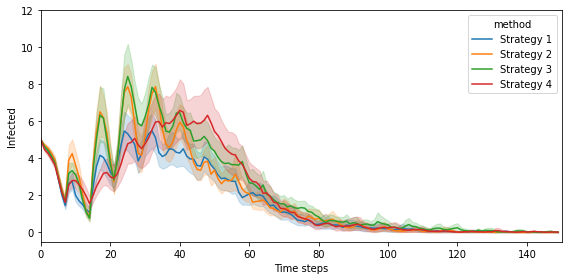

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 150)
plt.ylim(top = 12)
plt.tight_layout()

# Chung-Lu

In [ ]:
edge_list = np.round(np.random.power(0.5,500)*6 + 4)
G_temp = nx.expected_degree_graph([int(i) for i in edge_list],selfloops = False)
[G_temp.add_edge(i, random.randint(0,499)) for i in list(nx.isolates(G_temp))]
G = nx.convert_node_labels_to_integers(G_temp)

print("# of nodes: ", G.number_of_nodes())
print("Average degree: ", 2*G.number_of_edges()/G.number_of_nodes())
print(list(nx.isolates(G)))

# of nodes:  500
Average degree:  6.348
[]


In [ ]:
def network_gen():
  edge_list = np.round(np.random.power(0.5,500)*6 + 4)
  G_temp = nx.expected_degree_graph([int(i) for i in edge_list],selfloops = False)
  [G_temp.add_edge(i, random.randint(0,499)) for i in list(nx.isolates(G_temp))]
  G = nx.convert_node_labels_to_integers(G_temp)
  return G


##Testing Strategy _0

In [ ]:
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, avg_node_degree=6, data_G = network_gen())
for i in range(steps):
    model.step()
print (time.time()-st)
#agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:30])


2.2497193813323975
      Susceptible  Exposed  Infected  Removed
Step                                         
0             495        0         5        0
1             491        4         5        0
2             489        6         5        0
3             488        7         5        0
4             486        9         5        0
5             484       11         5        0
6             483       12         5        0
7             482       13         5        0
8             482        9         8        1
9             480        9        10        1
10            476       12        11        1
11            473       13        12        2
12            468       16        13        3
13            463       20        13        4
14            457       25         8       10
15            452       30         8       10
16            448       32         7       13
17            442       34        10       14
18            436       37        11       16
19            4

In [ ]:
print("max_outbreak_size: ", get_column_data(model).Infected.max())
print("number_of_uninfected:",get_column_data(model).Susceptible.min())

max_outbreak_size:  120
number_of_uninfected: 34


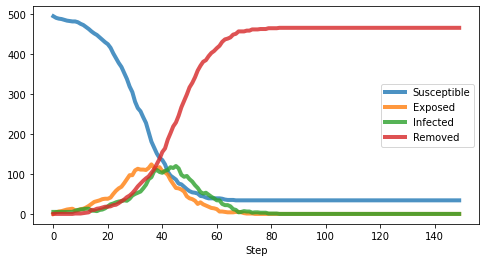

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
475                           9            9  0.223775
327                           8           16  0.630240
144                           8           11  0.187031
131                           7           13  0.226297
334                           7           10  0.238371
439                           7           10  0.943028
349                           6            9  0.138882
259                           6           14  0.295325
254                           6            9  0.310532
383                           6           11  0.202400
38                            6           10  0.320223
85                            6            9  0.304366
321                           6           15  0.351400
92                            5           10  0.147186
246                           5            9  0.116951
180                           5           10  0.277215
87                            5           16  0.191297
330                           5           10  0.095063
294                           5            6  0.403773
215                           4            5  0.402556

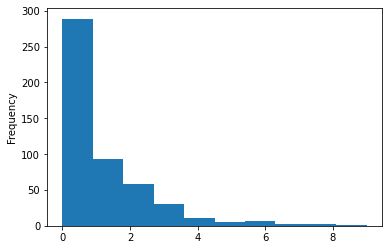

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

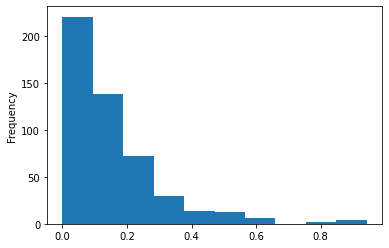

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _1

In [ ]:
#model set_up for strategy 1
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    ind = random.sample(range(1,pop+1), pop)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0

    if np.mod(pop, capacity) != 0:
        null_tail = [0] * (capacity - np.mod(pop, capacity))
        finish_flag = int(np.ceil(pop/capacity))
        ind.extend(null_tail)
        t_order = np.array(ind).reshape(finish_flag, capacity)
    else:
      finish_flag = int(pop/capacity)
      t_order = np.array(ind).reshape(finish_flag, capacity)
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            if test_key < finish_flag:
                temp = model.datacollector.get_agent_vars_dataframe()
                temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
                infection_matrix = csr_matrix(temp.values)
                for v in t_order[test_key]:
                    if v == 0:
                        test_key = 0
                        break
                    n_tests += 1
                    if infection_matrix[v-1, i] == 2:
                        model.schedule.agents[v-1].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v,i))) 
                    if infection_matrix[v-1, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v-1].exposed_time) > 4:
                            model.schedule.agents[v-1].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v,i)))
                test_key += 1
                if test_key == finish_flag:
                    test_key = 0
                
            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()

    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      15.002427               49        10350                  6   
1      13.566669               76        10350                  5   
2      15.124338              118        10350                  8   
3      12.971033               32        10350                  5   
4      12.926919               25        10350                  5   
..           ...              ...          ...                ...   
95     12.911906              136        10350                  5   
96     12.858271              128        10350                  9   
97     12.719057               40        10350                  5   
98     13.006122              113        10350                  7   
99     12.995191               88        10350                  5   

    max_2_trans  num_of_S  
0            11       439  
1             7       407  
2            11       352  
3             6       458  
4             6       470  
..          ...       ...  
95           11       335  
96           12       346  
97            9       453  
98            8       364  
99            8       396  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  13.069547469615935 0.06602091787448951
Average_found_positives:  94.2 6.259602724025404
Average_total_tests:  10350.0 0.0
Average_max_outbreak_size:  7.11 0.268890349774811
Average_max_2_trans: 8.57 0.3153497337012583
Average_number_of_uninfected: 384.4 7.691264886581112


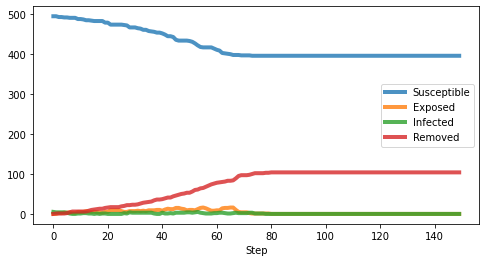

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


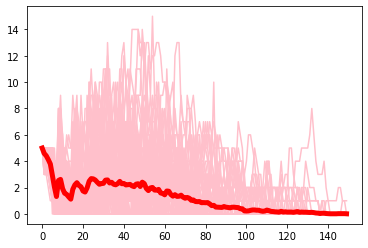

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)

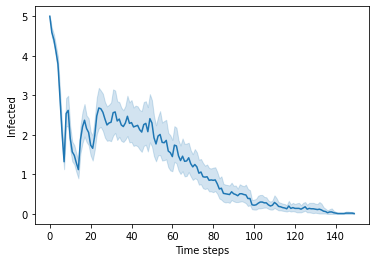

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_1 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
24                            8            9  0.688737
398                           5            7  0.353030
72                            5            9  0.292219
252                           4            9  0.466295
377                           4           16  0.114857
108                           4            5  0.286827
48                            4           13  0.109467
172                           4            8  0.245902
363                           4            8  0.116269
30                            4            5  0.762252
197                           4            9  0.305503
258                           3            8  0.091908
184                           3            6  0.095458
238                           3            7  0.072591
242                           3            7  0.559882
260                           3            7  0.189778
223                           3            6  0.236708
103                           3           11  0.066830
200                           2           10  0.060351
114                           2            9  0.115881

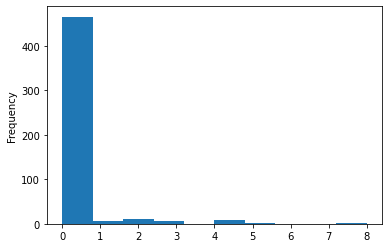

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

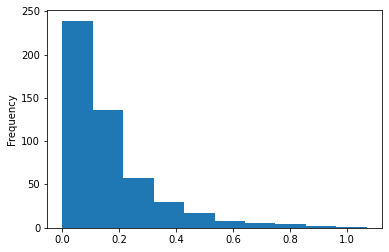

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _2

In [ ]:
#model set_up for strategy 2
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = random_groups(model.G, group_size)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0

      
    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      12.656236              146         1503                 10   
1      13.033846              232         1666                 12   
2      14.793771              207         1664                 10   
3      14.669698               10          935                  5   
4      13.114032              172         1432                  9   
..           ...              ...          ...                ...   
95     13.263429              263         1735                 16   
96     13.236876              167         1472                 10   
97     13.150263              223         1676                 10   
98     13.078167              141         1363                 12   
99     13.220517               17          943                  5   

    max_2_trans  num_of_S  
0             9       335  
1             8       248  
2            11       279  
3             6       484  
4            11       312  
..          ...       ...  
95            9       218  
96            9       315  
97            8       262  
98            7       341  
99            5       478  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  13.229158012866973 0.06184520838861609
Average_found_positives:  145.54 7.70075976836708
Average_total_tests:  1400.77 25.550432817698358
Average_max_outbreak_size:  8.62 0.3145559640913752
Average_max_2_trans: 8.52 0.2536521120341676
Average_number_of_uninfected: 339.17 8.265090942199503


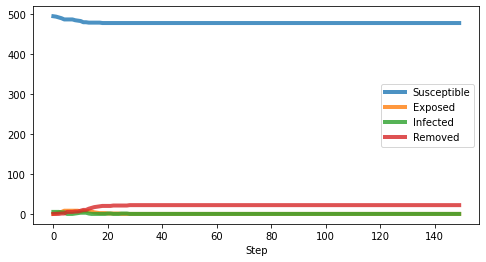

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


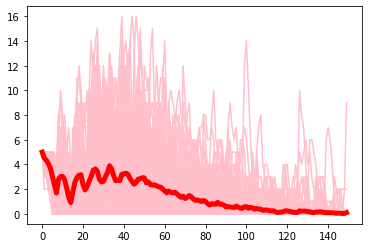

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


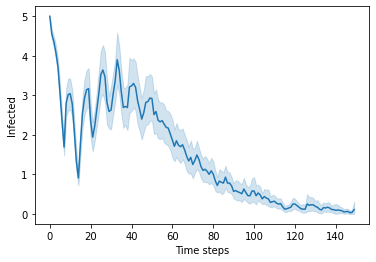

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_2 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
100                           5            6  0.371669
28                            4            8  0.249058
128                           3           10  0.238550
243                           2            8  0.091077
399                           1            7  0.068469
305                           1            4  0.037096
206                           1           11  0.218966
335                           0            4  0.272553
336                           0            7  0.057612
337                           0            9  0.237703
338                           0            6  0.041192
339                           0            3  0.191892
340                           0            2  0.125844
341                           0            2  0.109033
342                           0            9  0.042880
343                           0            5  0.543390
344                           0            4  0.087009
334                           0            8  0.060818
332                           0            3  0.005714
333                           0           10  0.037519

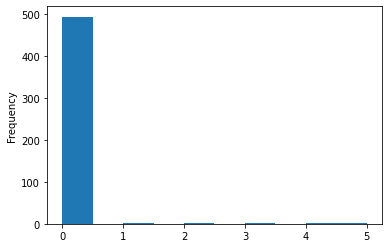

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

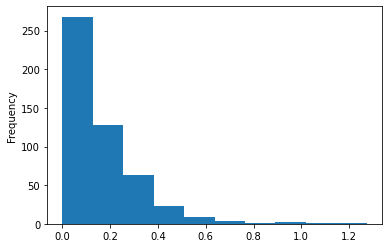

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _3

In [ ]:
#model set_up for strategy 3
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    random.shuffle(rand_groups)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      15.252124              235         1779                 12   
1      15.167667              246         1755                 17   
2      13.301183              264         1707                 14   
3      13.195333               65         1175                  9   
4      13.695074              249         1776                 11   
..           ...              ...          ...                ...   
95     15.255832              117         1271                 10   
96     15.321503              231         1702                 13   
97     13.472178              133         1435                 11   
98     13.586213              269         1758                 16   
99     13.441066              205         1630                 12   

    max_2_trans  num_of_S  
0             9       234  
1            10       226  
2            10       212  
3             8       429  
4            11       233  
..          ...       ...  
95           11       367  
96           13       240  
97            9       360  
98           10       202  
99           11       277  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  13.802465162277223 0.07996515027162944
Average_found_positives:  200.96 6.937148134674958
Average_total_tests:  1604.02 23.770506213721358
Average_max_outbreak_size:  11.83 0.3626654968786839
Average_max_2_trans: 9.97 0.20862948647365892
Average_number_of_uninfected: 275.4 7.687337088690174


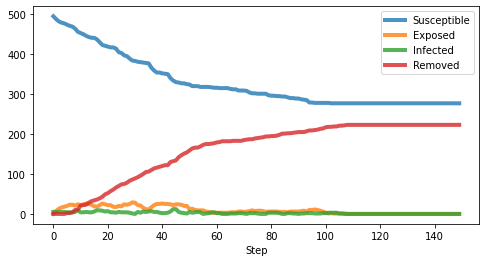

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


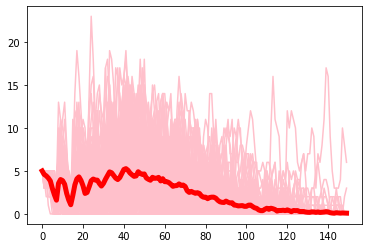

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


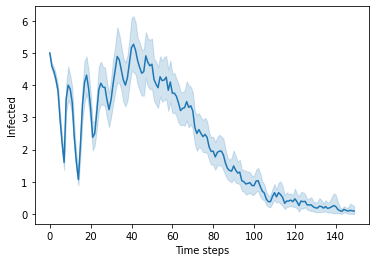

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_3 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
67                           11           11  0.224891
76                           10           10  0.224269
45                            9           15  0.251703
493                           5            7  0.223057
57                            5            9  0.355057
419                           5           13  0.216705
461                           5           14  0.127908
282                           5            6  0.480172
17                            5            5  0.235230
124                           5           11  0.224278
197                           5            6  0.461849
1                             4            9  0.149370
116                           4           12  0.206645
293                           4            7  0.443560
78                            4            7  0.494309
378                           4           13  0.271357
87                            4           10  0.270345
337                           4           12  0.215382
180                           4            9  0.331263
309                           4            8  0.336693

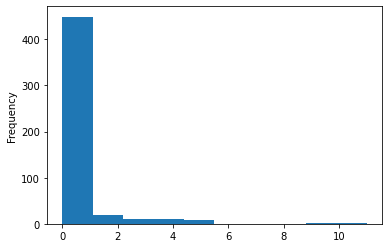

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

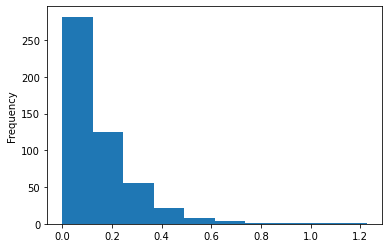

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _4

In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)
            else:
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      14.265203               20          906                  5   
1      14.480694               63         1156                  5   
2      15.514879              217         1808                  9   
3      14.769193               92         1340                  5   
4      14.959468              119         1394                  5   
..           ...              ...          ...                ...   
95     12.971207                7          906                  5   
96     14.792424              252         1814                 14   
97     13.865469              136         1419                  7   
98     14.051799              104         1273                  5   
99     14.988480              281         2181                 14   

    max_2_trans  num_of_S  
0            13       476  
1             5       431  
2             9       257  
3             7       400  
4            10       365  
..          ...       ...  
95            3       489  
96           13       220  
97            6       351  
98            8       384  
99           10       189  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  14.34719242811203 0.10681421450470492
Average_found_positives:  145.92 8.315407143345174
Average_total_tests:  1502.2 37.16702676819709
Average_max_outbreak_size:  8.68 0.3196841875945381
Average_max_2_trans: 8.66 0.2796895826202017
Average_number_of_uninfected: 338.7 9.096314049818712


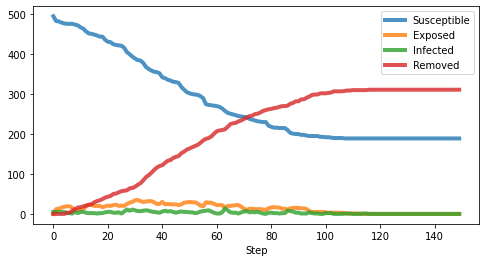

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


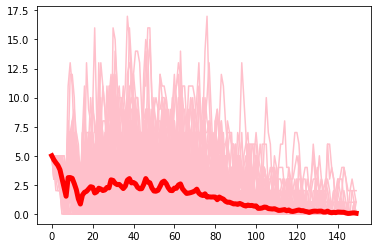

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


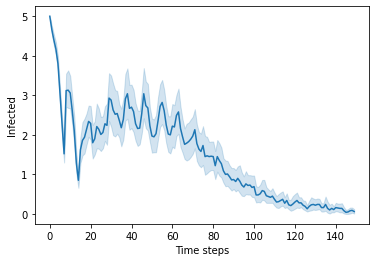

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_4 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
137                          10           10  0.439352
476                           8           12  0.172761
10                            8           10  0.260938
315                           7           13  0.552276
99                            7           14  0.268744
71                            7           14  0.269616
226                           7            8  0.435008
90                            7           10  0.238312
259                           6            9  0.415735
486                           6           11  0.208806
341                           6            9  0.207352
136                           6           13  0.236176
362                           5           11  0.425369
322                           5            8  0.570779
161                           5            9  0.196888
402                           5            9  0.412096
62                            5           10  0.643862
109                           5            9  0.396348
351                           4           10  0.133750
80                            4            9  0.296266

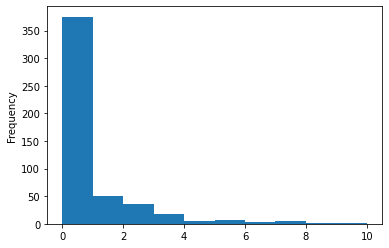

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

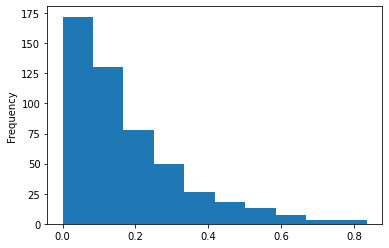

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(329, 102), (180, 102), (175, 106), (482, 107), (113, 109)]

In [ ]:
group_df

Group  Degree  Intra_C  \
21  [248, 462, 184, 226, 260, 313, 229, 374, 453, 96]      68        7   
24  [262, 251, 322, 239, 332, 317, 92, 123, 241, 301]      60        7   
13  [403, 487, 475, 477, 408, 264, 270, 422, 90, 108]      60        9   
32         [29, 43, 290, 7, 70, 30, 53, 50, 200, 164]      59        7   
11  [338, 347, 412, 115, 203, 357, 376, 495, 371, ...      58       10   
27   [280, 399, 297, 112, 204, 492, 63, 119, 228, 99]      54        7   
42      [359, 441, 64, 67, 65, 135, 409, 490, 12, 39]      49        8   
40  [494, 113, 446, 107, 383, 151, 160, 496, 333, ...      56        8   
1       [133, 265, 326, 393, 227, 6, 8, 415, 72, 136]      58        9   
47    [16, 318, 95, 101, 465, 287, 325, 499, 78, 205]      56        8   
46   [104, 315, 457, 37, 45, 463, 406, 440, 461, 497]      60        7   
12    [365, 427, 397, 74, 87, 375, 449, 386, 24, 201]      67        9   
48  [405, 146, 263, 413, 468, 439, 470, 444, 54, 282]      56        8   
31        [150, 26, 44, 118, 126, 1, 358, 59, 472, 4]      63        8   
23  [215, 308, 352, 395, 294, 370, 428, 141, 199, ...      62        8   
15    [68, 114, 291, 171, 331, 268, 38, 198, 69, 419]      60        7   
35    [256, 145, 364, 328, 421, 60, 285, 77, 410, 86]      58        7   
49     [447, 452, 491, 46, 55, 458, 31, 33, 464, 473]      55        8   
0     [71, 148, 192, 274, 221, 323, 292, 467, 75, 89]      54       10   
41  [131, 245, 240, 340, 302, 110, 143, 389, 58, 158]      52       10   
5   [258, 362, 343, 423, 310, 319, 153, 320, 279, ...      67       11   
25  [336, 469, 296, 300, 394, 21, 149, 247, 482, 459]      50        7   
2   [179, 155, 307, 214, 424, 220, 116, 209, 249, ...      47        9   
20    [235, 28, 32, 162, 384, 218, 41, 202, 181, 312]      55        8   
34   [137, 125, 450, 83, 213, 154, 244, 57, 139, 132]      51        6   
33       [267, 17, 128, 20, 391, 23, 36, 97, 368, 56]      52        8   
17  [157, 271, 166, 272, 380, 456, 117, 238, 190, ...      52        7   
3   [189, 230, 232, 250, 236, 175, 195, 298, 231, ...      48        9   
36  [339, 210, 252, 120, 121, 122, 223, 178, 193, ...      55        8   
30  [299, 390, 418, 402, 398, 277, 388, 407, 309, 84]      51        8   
39         [438, 11, 61, 479, 5, 66, 34, 93, 94, 186]      78        9   
28  [212, 234, 314, 493, 140, 436, 476, 483, 426, 76]      79        8   
44  [177, 445, 13, 138, 432, 484, 344, 460, 354, 425]      72       10   
22  [194, 211, 276, 311, 480, 224, 355, 346, 80, 100]      72        9   
29   [217, 129, 219, 329, 369, 35, 191, 42, 284, 207]      76        8   
18   [165, 435, 167, 79, 98, 130, 176, 253, 106, 169]      68        8   
6    [266, 286, 273, 62, 82, 316, 152, 180, 327, 360]      67        9   
37  [401, 261, 478, 349, 350, 278, 443, 382, 474, ...      75        8   
8     [306, 430, 414, 22, 222, 373, 404, 434, 27, 52]      77       10   
14   [392, 51, 187, 330, 433, 156, 237, 159, 182, 47]      85       11   
4     [255, 351, 295, 471, 304, 105, 321, 377, 9, 15]      83       11   
19  [168, 289, 288, 416, 144, 188, 161, 174, 197, ...      68        7   
10       [337, 0, 3, 367, 40, 91, 356, 366, 381, 485]      61        9   
9    [324, 348, 363, 18, 335, 334, 25, 225, 345, 417]      57        9   
38       [2, 48, 19, 81, 342, 442, 448, 73, 233, 489]      78        8   
7   [281, 305, 303, 498, 353, 88, 103, 396, 134, 142]      66        9   
43  [208, 341, 411, 109, 147, 481, 259, 437, 420, ...      63        7   
26  [14, 102, 254, 361, 257, 429, 269, 431, 293, 385]      62        9   
16   [206, 486, 163, 246, 185, 10, 170, 275, 85, 172]      68       10   
45  [451, 111, 173, 488, 49, 183, 454, 124, 379, 455]      70        7   

       order  record  flag  
21  0.003761      18     1  
24  0.002709      18     1  
13  0.002474      18     1  
32  0.001844      18     1  
11  0.001450      18     1  
27  0.001383      18     1  
42  0.002681      17     0  
40  0.002483      17     0  
1   0.002337

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
137                          10           10  0.439352
476                           8           12  0.172761
10                            8           10  0.260938
315                           7           13  0.552276
99                            7           14  0.268744
71                            7           14  0.269616
226                           7            8  0.435008
90                            7           10  0.238312
259                           6            9  0.415735
486                           6           11  0.208806
341                           6            9  0.207352
136                           6           13  0.236176
362                           5           11  0.425369
322                           5            8  0.570779
161                           5            9  0.196888
402                           5            9  0.412096
62                            5           10  0.643862
109                           5            9  0.396348
351                           4           10  0.133750
80                            4            9  0.296266

##Testing Strategy_4_high_2


In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            else:
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)              
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      13.967333               99         1211                 10   
1      14.798705              252         1652                 27   
2      13.859301               19          946                  5   
3      14.999765              157         1358                  8   
4      15.658013              118         1329                  7   
..           ...              ...          ...                ...   
95     14.438016              164         1388                 13   
96     14.319188              140         1360                  7   
97     13.638107               89         1194                  6   
98     13.075156               22          946                  5   
99     14.497388              215         1437                 15   

    max_2_trans  num_of_S  
0             8       376  
1            11       166  
2             4       475  
3             9       323  
4             8       365  
..          ...       ...  
95           13       311  
96           10       342  
97           10       399  
98            8       475  
99           10       246  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  14.306386668682098 0.08272562453988745
Average_found_positives:  109.63 7.7054834862957025
Average_total_tests:  1232.54 24.515929350509882
Average_max_outbreak_size:  8.78 0.5567909496536034
Average_max_2_trans: 8.45 0.2889811430008903
Average_number_of_uninfected: 370.26 9.404164347282913


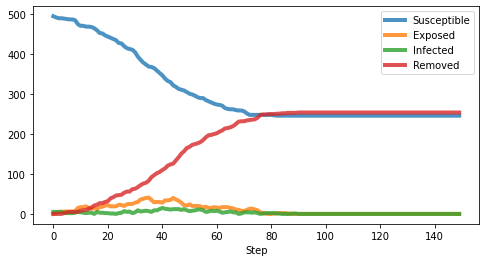

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


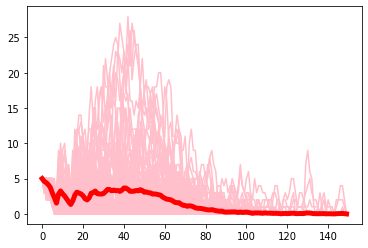

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


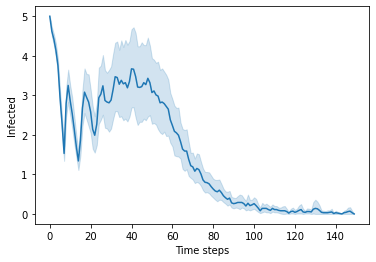

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_5 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
320                          10           12  0.538526
450                           9           10  0.498846
321                           8           13  0.459713
495                           8           12  0.569907
194                           8            9  0.383192
243                           7           11  0.312428
480                           6           10  0.645505
114                           6           11  0.154194
436                           5            8  0.192813
476                           5           10  0.397706
411                           5            5  0.271479
465                           5            8  0.691396
414                           5            8  0.344985
275                           5            6  0.166732
463                           5            7  0.853937
497                           5            9  0.422997
237                           4            7  0.147125
208                           4            9  0.105674
4                             4            7  0.050350
424                           4            6  0.224342

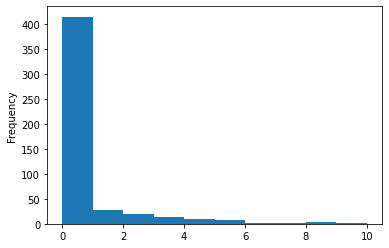

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

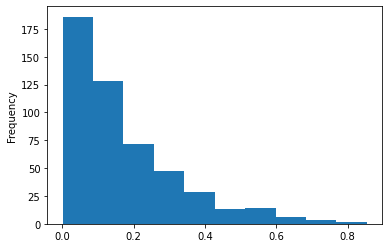

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(192, 75), (479, 76), (133, 81), (108, 85), (64, 89)]

In [ ]:
group_df

Group  Degree  Intra_C  \
37  [123, 302, 478, 44, 115, 376, 392, 236, 277, 482]      70        8   
8   [310, 418, 408, 461, 36, 272, 325, 356, 367, 479]      83       11   
38  [151, 191, 99, 344, 143, 270, 486, 140, 331, 322]      46        7   
40     [496, 57, 95, 211, 280, 237, 358, 499, 0, 101]      72       10   
9    [315, 390, 361, 75, 221, 378, 487, 428, 41, 249]      58        9   
3      [233, 283, 388, 14, 22, 265, 282, 285, 13, 29]      54       10   
27  [383, 264, 287, 97, 110, 138, 444, 108, 368, 340]      62        8   
49   [424, 498, 458, 81, 391, 437, 448, 462, 65, 194]      60        8   
36         [80, 7, 8, 119, 135, 469, 98, 149, 42, 88]      39        7   
14  [127, 133, 258, 224, 393, 403, 473, 121, 275, ...      50        8   
2   [166, 321, 381, 279, 284, 202, 308, 300, 33, 106]      64       11   
28  [369, 107, 347, 306, 414, 176, 278, 232, 389, ...      57        7   
39   [379, 480, 485, 493, 26, 142, 35, 216, 177, 269]      80       11   
35  [435, 447, 172, 195, 190, 363, 334, 405, 468, 20]      44        6   
43   [421, 439, 412, 463, 396, 263, 72, 327, 416, 23]      53        7   
21      [225, 83, 170, 48, 257, 89, 209, 2, 126, 227]      53        8   
17   [359, 404, 74, 201, 243, 380, 492, 45, 217, 268]      71        7   
23      [136, 50, 220, 39, 85, 113, 114, 40, 86, 125]      58        7   
4    [241, 9, 109, 311, 316, 314, 495, 417, 132, 160]      61       10   
26    [330, 78, 292, 90, 111, 59, 187, 128, 181, 210]      60        7   
18   [305, 323, 332, 254, 286, 397, 28, 69, 386, 426]      59        6   
33  [441, 401, 467, 427, 471, 430, 477, 303, 454, ...      60        7   
47  [131, 266, 148, 168, 476, 488, 54, 197, 252, 346]      58        9   
30  [219, 208, 313, 223, 360, 171, 259, 196, 276, ...      57        7   
41     [31, 112, 146, 200, 341, 87, 335, 394, 34, 64]      60        8   
46  [70, 165, 436, 474, 117, 169, 373, 450, 443, 459]      60        8   
15  [298, 130, 167, 253, 163, 182, 134, 141, 374, 58]      57        7   
48    [336, 11, 79, 349, 432, 410, 490, 481, 52, 309]      46        8   
7   [288, 489, 297, 362, 338, 77, 475, 409, 100, 215]      55        9   
34     [370, 406, 19, 38, 375, 61, 102, 60, 185, 342]      55        6   
20   [434, 470, 105, 157, 350, 43, 68, 204, 326, 456]      52        8   
32  [357, 222, 246, 250, 366, 231, 294, 248, 411, ...      44        7   
12        [491, 84, 212, 32, 62, 104, 351, 3, 82, 94]      73        9   
6       [261, 329, 384, 442, 355, 15, 73, 433, 6, 63]      59        9   
44     [55, 472, 67, 93, 419, 234, 337, 484, 91, 162]      59        9   
1     [118, 429, 307, 47, 184, 153, 299, 180, 10, 30]      45        9   
22     [466, 154, 353, 158, 207, 5, 53, 137, 144, 12]      56        8   
13  [230, 425, 213, 255, 156, 164, 296, 339, 145, ...      66        9   
11  [333, 457, 445, 205, 382, 398, 49, 229, 464, 465]      45        9   
25    [188, 312, 400, 66, 226, 96, 173, 56, 281, 206]      63        6   
45    [420, 92, 179, 440, 16, 76, 422, 174, 273, 423]      76        8   
24   [239, 46, 438, 364, 399, 116, 240, 214, 256, 51]      61        7   
10    [328, 348, 345, 4, 228, 402, 494, 446, 37, 247]      79        9   
19  [451, 497, 293, 377, 455, 147, 319, 371, 483, ...      65        7   
5   [244, 25, 178, 317, 343, 304, 395, 452, 198, 354]      53        9   
42     [372, 24, 139, 453, 161, 251, 385, 71, 17, 21]      69        9   
29  [175, 129, 189, 152, 199, 238, 415, 159, 291, ...      55        6   
16  [460, 150, 352, 318, 449, 192, 407, 290, 324, ...      61        7   
0      [103, 267, 124, 1, 18, 193, 301, 235, 27, 320]      52        9   
31  [274, 260, 387, 186, 242, 289, 431, 203, 271, ...      67        6   

       order  record  flag  
37  0.000376      19     1  
8   0.000372      21     1  
38  0.000364      17     1  
40  0.000360      21     1  
9   0.000357      19     1  
3   0.000356      19     1  
27  0.000667      17     0  
49  0.000653      17     0  
36  0.000653

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
320                          10           12  0.538526
450                           9           10  0.498846
321                           8           13  0.459713
495                           8           12  0.569907
194                           8            9  0.383192
243                           7           11  0.312428
480                           6           10  0.645505
114                           6           11  0.154194
436                           5            8  0.192813
476                           5           10  0.397706
411                           5            5  0.271479
465                           5            8  0.691396
414                           5            8  0.344985
275                           5            6  0.166732
463                           5            7  0.853937
497                           5            9  0.422997
237                           4            7  0.147125
208                           4            9  0.105674
4                             4            7  0.050350
424                           4            6  0.224342

##Vis

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_5['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_5])
temp = temp.reset_index()

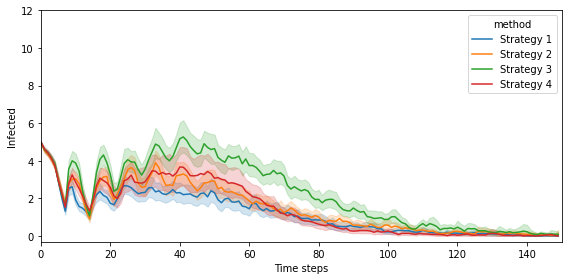

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 150)
plt.ylim(top = 12)
plt.tight_layout()

# ER

In [ ]:
G_temp = nx.erdos_renyi_graph(n=500, p=0.012)
[G_temp.add_edge(i, random.randint(0, 499)) for i in list(nx.isolates(G_temp))]
G = nx.convert_node_labels_to_integers(G_temp)

print("# of nodes: ", G.number_of_nodes())
print("Average degree: ", 2*G.number_of_edges()/G.number_of_nodes())
print(list(nx.isolates(G)))

# of nodes:  500
Average degree:  6.128
[]


In [ ]:
def network_gen():
  G_temp = nx.erdos_renyi_graph(n=500, p=0.012)
  [G_temp.add_edge(i, random.randint(0, 499)) for i in list(nx.isolates(G_temp))]
  G = nx.convert_node_labels_to_integers(G_temp)
  return G

##Testing Strategy _0

In [ ]:
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, avg_node_degree=6, data_G = network_gen())
for i in range(steps):
    model.step()
print (time.time()-st)
#agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:30])


2.3539719581604004
      Susceptible  Exposed  Infected  Removed
Step                                         
0             495        0         5        0
1             494        1         5        0
2             491        4         4        1
3             491        4         4        1
4             490        5         4        1
5             490        5         4        1
6             490        5         2        3
7             490        5         2        3
8             490        4         3        3
9             480       11         5        4
10            476       15         4        5
11            473       17         4        6
12            472       18         4        6
13            472       18         3        7
14            472       18         3        7
15            472       18         2        8
16            464       16        11        9
17            459       17        12       12
18            451       22        14       13
19            4

In [ ]:
print("max_outbreak_size: ", get_column_data(model).Infected.max())
print("number_of_uninfected:",get_column_data(model).Susceptible.min())

max_outbreak_size:  134
number_of_uninfected: 20


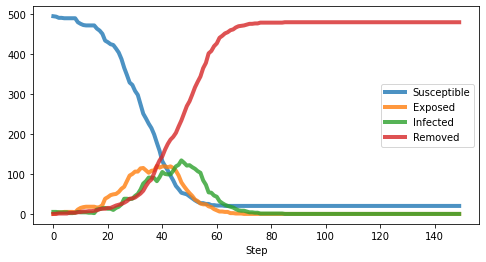

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
168                           9           11  0.401743
135                           9           10  0.298429
313                           8           10  0.332593
82                            8            9  0.311453
336                           8            9  0.923088
159                           7           10  0.195381
152                           6            7  0.554861
72                            6           10  0.141048
176                           6            8  0.299365
9                             6           12  0.344891
383                           6           16  0.070258
45                            5           10  0.205972
88                            5            9  0.139596
387                           5           10  0.150225
400                           5            6  0.230567
84                            5           10  0.264808
278                           5            8  0.385714
93                            5            8  0.444415
148                           5            8  0.098662
166                           5            8  0.122284

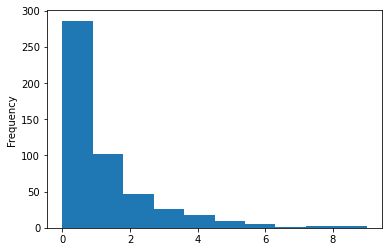

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

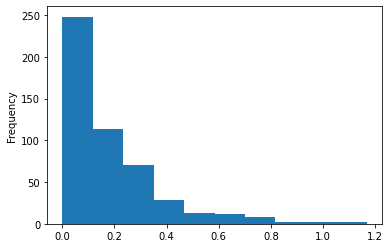

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _1

In [ ]:
#model set_up for strategy 1
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    ind = random.sample(range(1,pop+1), pop)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0

    if np.mod(pop, capacity) != 0:
        null_tail = [0] * (capacity - np.mod(pop, capacity))
        finish_flag = int(np.ceil(pop/capacity))
        ind.extend(null_tail)
        t_order = np.array(ind).reshape(finish_flag, capacity)
    else:
      finish_flag = int(pop/capacity)
      t_order = np.array(ind).reshape(finish_flag, capacity)
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            if test_key < finish_flag:
                temp = model.datacollector.get_agent_vars_dataframe()
                temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
                infection_matrix = csr_matrix(temp.values)
                for v in t_order[test_key]:
                    if v == 0:
                        test_key = 0
                        break
                    n_tests += 1
                    if infection_matrix[v-1, i] == 2:
                        model.schedule.agents[v-1].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v,i))) 
                    if infection_matrix[v-1, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v-1].exposed_time) > 4:
                            model.schedule.agents[v-1].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v,i)))
                test_key += 1
                if test_key == finish_flag:
                    test_key = 0
                
            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()

    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      12.458558               59        10350                  7   
1      15.846862               97        10350                  5   
2      12.377825              171        10350                 11   
3      12.887273                7        10350                  5   
4      12.620072               91        10350                  8   
..           ...              ...          ...                ...   
95     12.315727               14        10350                  5   
96     12.502147              155        10350                  8   
97     12.042717              130        10350                 11   
98     12.385674               44        10350                  6   
99     12.183382               69        10350                  7   

    max_2_trans  num_of_S  
0             7       429  
1             8       382  
2             9       290  
3             5       487  
4             9       389  
..          ...       ...  
95            5       481  
96            9       305  
97            8       345  
98            5       446  
99            9       416  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  12.560296051502227 0.08571317836294888
Average_found_positives:  90.91 5.6102016564703465
Average_total_tests:  10350.0 0.0
Average_max_outbreak_size:  6.87 0.22991214835148654
Average_max_2_trans: 7.82 0.219448344166858
Average_number_of_uninfected: 388.69 6.846966370944761


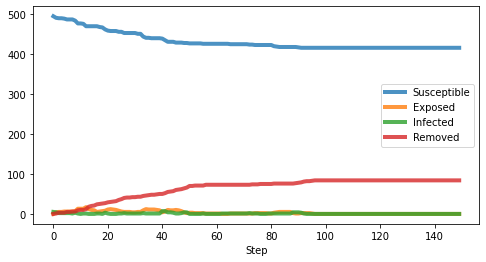

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


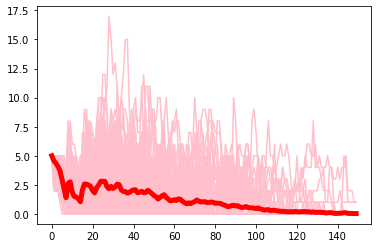

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)

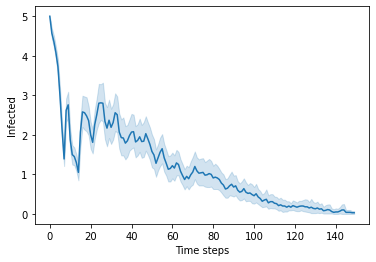

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_1 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
71                            9           10  0.477942
497                           5            8  0.111742
310                           4            6  0.182484
348                           4           12  0.252499
282                           4            8  0.401550
13                            3            5  0.688023
52                            3           11  0.134433
42                            3            4  0.210634
228                           3           11  0.109969
280                           3            4  0.787348
24                            3            4  0.108740
92                            3            7  0.461742
297                           3            5  0.767784
491                           3            9  0.106609
335                           2            7  0.055224
257                           2            4  0.229611
402                           2            7  0.121345
433                           2           11  0.323743
261                           2            8  0.107981
184                           2           11  0.050519

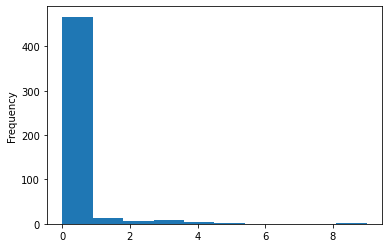

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

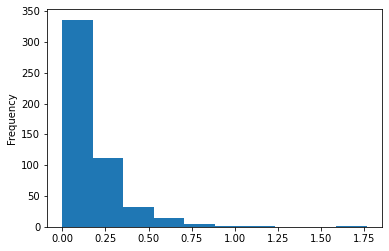

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _2

In [ ]:
#model set_up for strategy 2
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = random_groups(model.G, group_size)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0

      
    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      12.369647              128         1357                  6   
1      12.613374              102         1272                 10   
2      12.549606               27          993                  5   
3      12.265468              213         1678                  9   
4      16.115420              132         1404                  8   
..           ...              ...          ...                ...   
95     12.483027              183         1576                  9   
96     12.330105              178         1580                  6   
97     12.605562              215         1688                 11   
98     12.529429              232         1591                 10   
99     15.953192              265         1712                 14   

    max_2_trans  num_of_S  
0             8       357  
1            10       387  
2             5       467  
3            12       259  
4             9       356  
..          ...       ...  
95           12       306  
96           13       299  
97            8       273  
98            9       249  
99            7       213  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  12.719322385787963 0.08248228093392897
Average_found_positives:  136.35 7.732724309874577
Average_total_tests:  1374.16 26.18407149394456
Average_max_outbreak_size:  8.48 0.3227032285821971
Average_max_2_trans: 8.09 0.20601804373266522
Average_number_of_uninfected: 348.85 8.374134962110197


In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


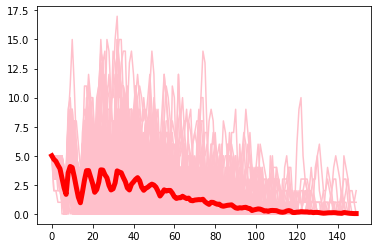

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


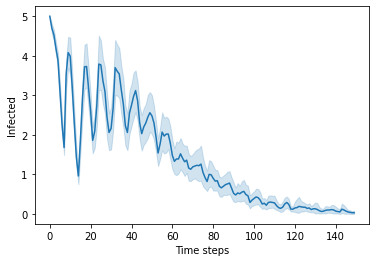

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_2 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
484                           7            9  0.215916
328                           7            9  0.339988
77                            7            9  1.416688
332                           7            9  0.364338
445                           6            9  0.522796
393                           6            9  0.463456
294                           5            8  0.465095
187                           5            9  0.284748
382                           5            6  0.430155
226                           5            8  0.595462
162                           5            8  0.182579
192                           5            6  0.154443
400                           5            6  0.418596
197                           5            6  0.448427
33                            4            7  0.223877
206                           4           10  0.441905
131                           4            5  0.381836
395                           4            7  0.100004
46                            4            6  0.185711
85                            4            7  0.462310

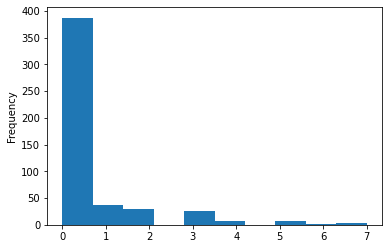

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

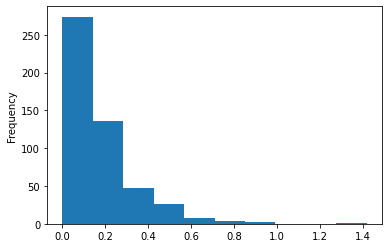

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _3

In [ ]:
#model set_up for strategy 3
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    random.shuffle(rand_groups)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      12.679517              243         1776                 11   
1      12.962817              221         1742                 11   
2      12.684213              240         1809                 14   
3      12.681079              170         1506                  9   
4      12.623780              124         1342                  6   
..           ...              ...          ...                ...   
95     13.277602              263         1741                 13   
96     12.959535              242         1725                 12   
97     13.277577              211         1611                  8   
98     13.464725              284         1895                 14   
99     12.996693              232         1698                 12   

    max_2_trans  num_of_S  
0             9       230  
1             7       257  
2             9       239  
3             8       307  
4             7       365  
..          ...       ...  
95            8       196  
96           13       233  
97            8       267  
98            7       183  
99            8       240  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  13.0845157623291 0.08721678205779584
Average_found_positives:  195.26 6.923618193465676
Average_total_tests:  1599.61 22.65340028438213
Average_max_outbreak_size:  10.48 0.3289039035611736
Average_max_2_trans: 8.64 0.2067155367438866
Average_number_of_uninfected: 282.07 7.559584925273626


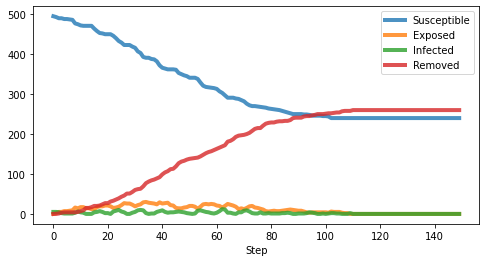

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_3 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
297                           8            9  1.052299
494                           7            9  0.196497
174                           7            9  0.644410
450                           6            9  0.913970
381                           6           10  0.638826
356                           6           13  0.116412
121                           6           12  0.312548
350                           5            6  0.392977
438                           5            8  0.601839
394                           5           12  0.372502
333                           5           10  0.147386
227                           5           10  0.252699
15                            5            7  0.106333
158                           4            6  0.288707
440                           4            6  0.201895
302                           4            9  0.159004
338                           4            6  0.378303
360                           4            8  0.633403
321                           4            7  0.360484
398                           4            8  0.093074

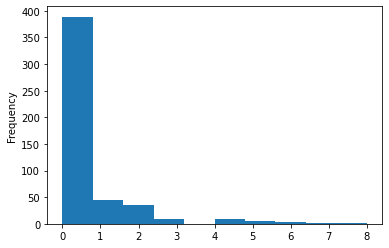

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _4

In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)
            else:
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      14.020855               18          946                  5   
1      14.395510              144         1550                  8   
2      13.998717               97         1304                  5   
3      14.210444               64         1111                  8   
4      14.621810              176         1652                  9   
..           ...              ...          ...                ...   
95     14.402736              178         1736                  7   
96     15.158035               64         1192                  9   
97     13.372216               29          986                  5   
98     13.317517               24          936                  5   
99     13.716711               30          985                  5   

    max_2_trans  num_of_S  
0             4       477  
1             8       339  
2             7       393  
3             9       425  
4             7       304  
..          ...       ...  
95           10       296  
96            8       426  
97            5       464  
98            6       470  
99            7       465  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  14.507633135318756 0.10120074033316395
Average_found_positives:  129.39 7.68026323991199
Average_total_tests:  1444.68 35.32336874928522
Average_max_outbreak_size:  7.74 0.2630896455890304
Average_max_2_trans: 7.75 0.20219752318917852
Average_number_of_uninfected: 355.74 8.426840475767914


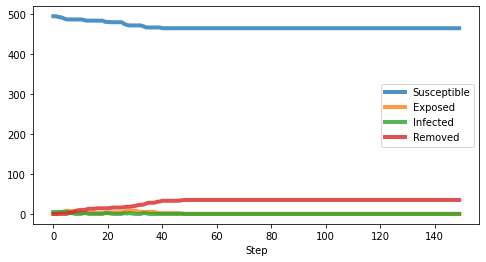

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


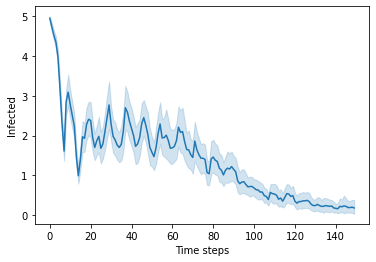

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_4 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
185                           7           10  0.446396
344                           4            6  0.175759
324                           3            4  0.644494
224                           2            6  0.075037
477                           2            9  0.212298
24                            2            9  0.069387
392                           2            5  0.370305
112                           2            4  0.063295
374                           2            7  0.223840
199                           1           11  0.044392
409                           1            4  0.091472
42                            1            6  0.171431
336                           1           13  0.063768
323                           0           12  0.276053
341                           0            7  0.266970
319                           0            5  0.032378
340                           0            6  0.295712
339                           0            2  0.162887
338                           0            4  0.227240
337                           0            9  0.266892

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(37, 38), (392, 39), (381, 39), (371, 46), (260, 47)]

In [ ]:
group_df

Group  Degree  Intra_C  \
13   [166, 47, 132, 94, 130, 278, 390, 102, 171, 231]      51        8   
35  [293, 314, 300, 421, 338, 458, 217, 319, 273, ...      69        7   
1     [262, 279, 284, 2, 13, 329, 100, 183, 382, 485]      64       10   
5    [347, 371, 425, 10, 37, 366, 473, 460, 152, 236]      62       10   
30  [95, 104, 133, 186, 150, 264, 309, 423, 122, 229]      66        8   
6      [352, 418, 400, 15, 32, 407, 451, 439, 76, 82]      60        9   
8   [392, 414, 472, 337, 488, 433, 480, 444, 169, ...      59        9   
38  [255, 282, 344, 378, 302, 405, 312, 396, 438, ...      73        9   
4   [318, 464, 477, 266, 288, 325, 137, 145, 328, ...      57        9   
39   [233, 19, 153, 43, 287, 440, 167, 213, 120, 165]      55        9   
0      [111, 243, 324, 39, 234, 162, 8, 77, 208, 220]      51        9   
45    [428, 93, 263, 121, 322, 426, 54, 106, 430, 21]      69        8   
9   [431, 441, 486, 219, 290, 447, 478, 498, 97, 177]      62        9   
18  [385, 476, 242, 256, 298, 387, 285, 355, 384, ...      69        6   
25      [80, 127, 18, 34, 74, 222, 90, 135, 207, 228]      58        9   
31  [147, 292, 158, 296, 173, 188, 144, 180, 194, ...      62        8   
44       [409, 61, 110, 411, 9, 30, 442, 33, 44, 416]      52        8   
42     [78, 87, 109, 493, 12, 181, 53, 143, 149, 154]      52        8   
12        [45, 202, 55, 69, 66, 85, 99, 134, 29, 115]      60        8   
19   [225, 257, 377, 345, 445, 280, 332, 434, 24, 62]      59        8   
16  [200, 331, 307, 336, 195, 376, 226, 375, 215, ...      67        7   
7    [368, 238, 271, 417, 457, 413, 422, 481, 42, 98]      51        9   
27  [270, 410, 191, 246, 286, 419, 63, 170, 118, 159]      58        8   
26      [51, 117, 89, 113, 84, 105, 91, 268, 56, 151]      58        8   
36  [245, 253, 383, 429, 227, 230, 252, 393, 240, ...      67        8   
33  [239, 354, 185, 274, 190, 199, 197, 289, 357, ...      63        8   
21   [381, 349, 25, 35, 412, 465, 427, 494, 311, 365]      60        7   
14    [4, 20, 125, 142, 161, 218, 129, 192, 138, 178]      69        7   
24         [16, 57, 139, 448, 1, 46, 60, 88, 73, 119]      53        7   
17   [398, 48, 251, 206, 241, 404, 27, 179, 237, 301]      56        7   
48    [59, 401, 499, 58, 65, 373, 471, 394, 126, 223]      67        9   
43    [497, 49, 124, 281, 335, 340, 432, 402, 22, 75]      71       10   
46   [38, 436, 334, 408, 469, 41, 184, 452, 475, 455]      64        6   
20   [308, 356, 369, 52, 96, 323, 391, 339, 370, 310]      49        8   
47   [492, 114, 182, 456, 235, 386, 470, 23, 26, 463]      65        9   
11      [435, 17, 108, 81, 196, 36, 83, 131, 265, 28]      64        9   
28    [176, 379, 203, 209, 67, 86, 157, 303, 92, 123]      61        7   
22  [372, 454, 343, 348, 399, 70, 140, 326, 406, 374]      68        7   
15    [210, 267, 254, 164, 204, 174, 5, 11, 175, 244]      70        8   
32  [201, 333, 380, 467, 163, 168, 276, 297, 221, ...      58        8   
37  [259, 283, 247, 363, 313, 362, 258, 261, 415, ...      56        8   
10    [437, 466, 459, 495, 449, 101, 172, 461, 6, 31]      60        9   
29  [128, 346, 68, 269, 148, 317, 136, 146, 212, 388]      61        8   
23  [446, 330, 358, 397, 193, 250, 79, 103, 361, 450]      61        8   
40     [189, 198, 484, 3, 72, 64, 112, 272, 420, 487]      72        8   
34  [205, 350, 304, 327, 275, 315, 403, 491, 211, ...      65        9   
3    [291, 14, 187, 316, 71, 156, 295, 395, 353, 462]      49        9   
49   [453, 479, 468, 155, 160, 482, 489, 496, 40, 50]      64        8   
41   [321, 389, 299, 305, 306, 367, 490, 214, 342, 0]      70        9   
2    [277, 294, 341, 7, 116, 360, 141, 249, 424, 483]      55        9   

       order  record  flag  
13  0.000005      18     1  
35  0.000005      18     1  
1   0.000005      18     1  
5   0.000005      18     1  
30  0.000004      18     1  
6   0.000004      18     1  
8   0.000008      17     0  
38  0.000008      17     0  
4   0.000008

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
185                           7           10  0.446396
344                           4            6  0.175759
324                           3            4  0.644494
224                           2            6  0.075037
477                           2            9  0.212298
24                            2            9  0.069387
392                           2            5  0.370305
112                           2            4  0.063295
374                           2            7  0.223840
199                           1           11  0.044392
409                           1            4  0.091472
42                            1            6  0.171431
336                           1           13  0.063768
323                           0           12  0.276053
341                           0            7  0.266970
319                           0            5  0.032378
340                           0            6  0.295712
339                           0            2  0.162887
338                           0            4  0.227240
337                           0            9  0.266892

##Testing Strategy_4_high_2


In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            else:
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)              
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      14.158323               91         1165                  8   
1      14.251747              121         1270                  9   
2      14.577065               94         1124                  9   
3      15.849428              192         1593                  7   
4      14.628073              114         1311                  7   
..           ...              ...          ...                ...   
95     14.294220              182         1507                 11   
96     14.218537               71         1083                  8   
97     13.738086               11          916                  5   
98     14.001074               64         1124                  6   
99     13.971992               17          936                  5   

    max_2_trans  num_of_S  
0            10       396  
1             8       364  
2            11       394  
3             8       291  
4             8       375  
..          ...       ...  
95            9       286  
96           11       418  
97            4       485  
98            8       424  
99            4       478  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  14.331900537014008 0.0645554939701283
Average_found_positives:  90.97 6.607456073071977
Average_total_tests:  1179.41 21.64335386825865
Average_max_outbreak_size:  7.09 0.32662801255535107
Average_max_2_trans: 7.76 0.2132575623015228
Average_number_of_uninfected: 394.53 7.7624381127675


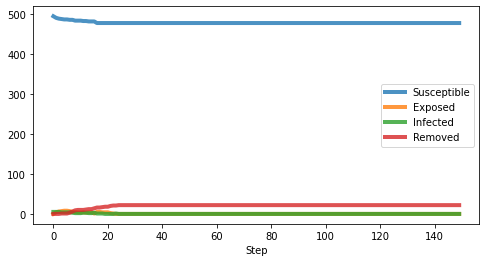

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


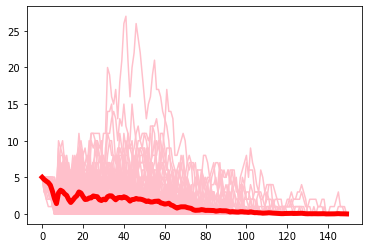

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_5 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
268                           4            5  0.327024
359                           2            7  0.016806
141                           2            5  0.134156
218                           2            6  0.183731
198                           2            8  0.095839
234                           2            8  0.038163
210                           1            3  0.115485
419                           1            4  0.094637
476                           1            4  0.069184
338                           0            6  0.178005
337                           0            4  0.222053
336                           0            6  0.114309
335                           0            8  0.412828
334                           0            2  0.114286
339                           0            6  0.216666
340                           0           10  0.068777
333                           0            3  0.374031
332                           0            5  0.037684
341                           0            9  0.395051
331                           0            5  0.090538

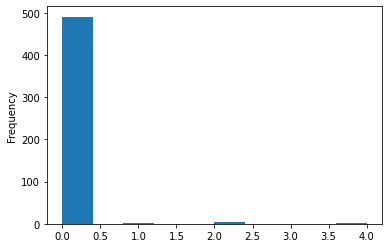

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

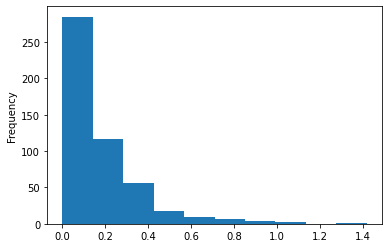

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(470, 17), (141, 18), (42, 20), (83, 20), (212, 21)]

In [ ]:
group_df

Group  Degree  Intra_C  \
10  [369, 387, 480, 116, 182, 388, 463, 489, 32, 159]      63        9   
48     [458, 494, 37, 46, 478, 487, 67, 75, 112, 185]      64        7   
7      [338, 394, 401, 483, 376, 40, 53, 412, 26, 28]      63        9   
8   [342, 495, 482, 20, 127, 436, 460, 484, 151, 284]      61        9   
25     [447, 493, 50, 88, 472, 22, 429, 65, 152, 314]      62        7   
49       [406, 427, 440, 8, 30, 437, 454, 452, 1, 86]      58        9   
2   [280, 496, 371, 51, 256, 305, 332, 419, 101, 420]      53        9   
32  [234, 491, 115, 161, 147, 312, 117, 130, 142, ...      68        8   
26       [100, 302, 18, 94, 66, 69, 24, 55, 113, 468]      66        8   
33  [119, 179, 167, 343, 132, 148, 164, 357, 156, ...      58        7   
41      [95, 144, 418, 43, 157, 39, 71, 41, 140, 424]      64        7   
40       [339, 91, 313, 368, 392, 414, 10, 16, 7, 92]      56        7   
31  [110, 129, 155, 316, 223, 286, 326, 367, 114, ...      61        8   
12  [264, 188, 242, 194, 281, 206, 99, 138, 149, 217]      57        8   
22   [337, 353, 364, 430, 474, 54, 62, 345, 470, 453]      54        6   
18  [363, 405, 249, 64, 231, 272, 386, 279, 404, 344]      45        7   
21  [402, 378, 209, 269, 347, 441, 455, 456, 334, ...      54        8   
15  [57, 241, 415, 350, 457, 172, 389, 216, 227, 254]      61        7   
9   [351, 448, 380, 475, 443, 255, 450, 479, 72, 446]      54        9   
16    [439, 335, 70, 211, 195, 311, 203, 208, 210, 4]      61        6   
13  [226, 267, 233, 290, 315, 31, 355, 163, 171, 198]      55        6   
44   [486, 45, 137, 146, 273, 191, 202, 490, 58, 106]      51        8   
29    [97, 240, 262, 358, 83, 250, 225, 293, 89, 134]      57        7   
35  [141, 328, 287, 416, 145, 197, 154, 383, 168, ...      75        8   
20  [300, 411, 370, 82, 135, 304, 377, 346, 481, 307]      65        9   
17   [199, 215, 327, 235, 462, 354, 435, 356, 42, 77]      63        8   
45    [44, 84, 294, 340, 385, 21, 413, 425, 105, 153]      63        9   
14   [301, 201, 485, 221, 36, 133, 165, 400, 341, 12]      59        8   
23   [73, 79, 384, 464, 395, 433, 372, 397, 374, 428]      58        8   
46       [391, 2, 78, 422, 85, 125, 444, 477, 11, 47]      62        7   
0   [258, 409, 431, 74, 126, 260, 118, 176, 271, 309]      59        9   
3   [289, 390, 13, 220, 224, 274, 321, 423, 362, 426]      57        9   
47      [29, 33, 461, 476, 14, 15, 98, 308, 467, 229]      68        8   
36  [192, 219, 173, 181, 183, 222, 170, 180, 263, ...      55        8   
27       [27, 120, 90, 283, 59, 61, 87, 259, 34, 218]      54        8   
39  [248, 324, 257, 407, 261, 373, 265, 382, 410, 76]      54        8   
37  [184, 247, 244, 245, 174, 236, 246, 497, 230, ...      50        8   
38  [252, 365, 196, 298, 266, 318, 331, 473, 352, ...      64        8   
43    [228, 35, 111, 465, 38, 49, 253, 303, 291, 320]      73        9   
5        [317, 25, 60, 349, 379, 348, 488, 466, 0, 3]      64        9   
30  [186, 213, 96, 187, 178, 238, 122, 143, 239, 243]      73        8   
24  [393, 131, 275, 438, 442, 403, 445, 432, 492, ...      63        7   
1     [268, 19, 212, 296, 299, 278, 417, 336, 63, 80]      61        9   
28  [121, 190, 150, 292, 160, 295, 48, 375, 158, 189]      59        7   
4    [310, 360, 451, 52, 162, 322, 323, 333, 23, 282]      57        9   
6     [330, 459, 381, 6, 17, 359, 471, 398, 109, 306]      57        9   
11  [68, 237, 214, 251, 102, 124, 469, 136, 193, 103]      71        9   
42        [5, 56, 81, 93, 128, 166, 449, 104, 123, 9]      68        7   
34  [177, 270, 139, 175, 169, 361, 204, 207, 232, ...      60        8   
19  [499, 288, 498, 319, 325, 297, 396, 329, 107, ...      60        8   

       order  record  flag  
10  0.000004      19     1  
48  0.000004      17     1  
7   0.000004      18     1  
8   0.000004      18     1  
25  0.000004      17     1  
49  0.000004      18     1  
2   0.000007      18     0  
32  0.000007      17     0  
26  0.000007

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
268                           4            5  0.327024
359                           2            7  0.016806
141                           2            5  0.134156
218                           2            6  0.183731
198                           2            8  0.095839
234                           2            8  0.038163
210                           1            3  0.115485
419                           1            4  0.094637
476                           1            4  0.069184
338                           0            6  0.178005
337                           0            4  0.222053
336                           0            6  0.114309
335                           0            8  0.412828
334                           0            2  0.114286
339                           0            6  0.216666
340                           0           10  0.068777
333                           0            3  0.374031
332                           0            5  0.037684
341                           0            9  0.395051
331                           0            5  0.090538

##Vis

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_5['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_5])
temp = temp.reset_index()

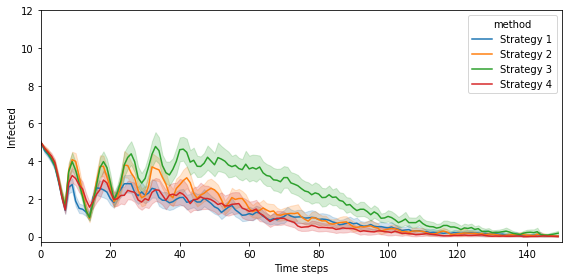

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 150)
plt.ylim(top = 12)
plt.tight_layout()

# Small World

In [ ]:
G_temp = nx.watts_strogatz_graph(n=500, k=6, p=0.1)
G = nx.convert_node_labels_to_integers(G_temp)

print("# of nodes: ", G.number_of_nodes())
print("Average degree: ", 2*G.number_of_edges()/G.number_of_nodes())
print(list(nx.isolates(G)))

# of nodes:  500
Average degree:  6.0
[]


In [ ]:
def network_gen():
  G_temp = nx.watts_strogatz_graph(n=500, k=6, p=0.1)
  G = nx.convert_node_labels_to_integers(G_temp)
  return G

##Testing Strategy _0

In [ ]:
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, avg_node_degree=6, data_G = network_gen())
for i in range(steps):
    model.step()
print (time.time()-st)
#agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:30])


2.4123125076293945
      Susceptible  Exposed  Infected  Removed
Step                                         
0             495        0         5        0
1             493        2         5        0
2             491        4         5        0
3             489        6         5        0
4             489        6         5        0
5             488        7         5        0
6             485       10         5        0
7             484       11         4        1
8             484        9         6        1
9             482        9         7        2
10            481        8         8        3
11            481        8         8        3
12            479        9         9        3
13            474       11        11        4
14            470       14        10        6
15            470       14         8        8
16            467       15         8       10
17            466       15         8       11
18            465       16         5       14
19            4

In [ ]:
print("max_outbreak_size: ", get_column_data(model).Infected.max())
print("number_of_uninfected:",get_column_data(model).Susceptible.min())

max_outbreak_size:  43
number_of_uninfected: 35


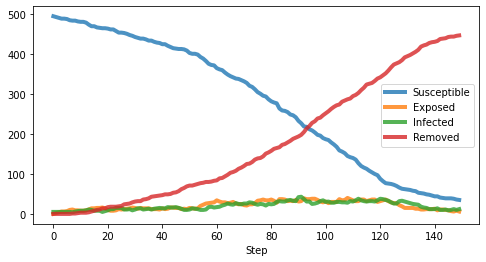

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
242                           6            7  0.292781
454                           6            7  0.520606
497                           6            8  0.338386
37                            6            7  0.227284
393                           6            6  0.087769
224                           5            7  0.328949
146                           5            6  0.726235
284                           5            7  0.211042
332                           5            7  0.143659
296                           5            7  0.401927
166                           5            7  0.334571
101                           5            6  0.267717
4                             5            6  0.246521
194                           4            6  0.208719
469                           4            7  0.435592
43                            4            7  0.257342
386                           4            7  0.449627
170                           4            6  0.897150
377                           4            7  0.169237
73                            4            6  0.558226

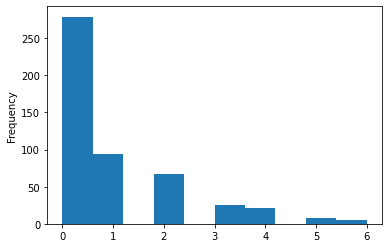

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

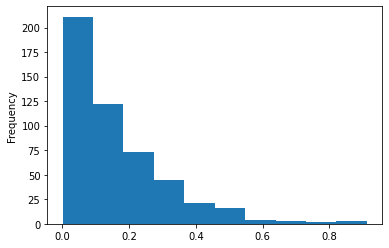

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _1

In [ ]:
#model set_up for strategy 1
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    ind = random.sample(range(1,pop+1), pop)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0

    if np.mod(pop, capacity) != 0:
        null_tail = [0] * (capacity - np.mod(pop, capacity))
        finish_flag = int(np.ceil(pop/capacity))
        ind.extend(null_tail)
        t_order = np.array(ind).reshape(finish_flag, capacity)
    else:
      finish_flag = int(pop/capacity)
      t_order = np.array(ind).reshape(finish_flag, capacity)
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            if test_key < finish_flag:
                temp = model.datacollector.get_agent_vars_dataframe()
                temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
                infection_matrix = csr_matrix(temp.values)
                for v in t_order[test_key]:
                    if v == 0:
                        test_key = 0
                        break
                    n_tests += 1
                    if infection_matrix[v-1, i] == 2:
                        model.schedule.agents[v-1].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v,i))) 
                    if infection_matrix[v-1, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v-1].exposed_time) > 4:
                            model.schedule.agents[v-1].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v,i)))
                test_key += 1
                if test_key == finish_flag:
                    test_key = 0
                
            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()

    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      12.535499               20        10350                  5   
1      12.994271               10        10350                  5   
2      12.684949               34        10350                  6   
3      12.579717               59        10350                  5   
4      12.799714               56        10350                  5   
..           ...              ...          ...                ...   
95     12.935009               19        10350                  5   
96     13.001258                9        10350                  5   
97     12.810812               42        10350                  6   
98     12.976511               26        10350                  5   
99     12.559957               30        10350                  7   

    max_2_trans  num_of_S  
0             6       474  
1             2       489  
2             5       463  
3             6       430  
4             6       429  
..          ...       ...  
95            6       478  
96            3       489  
97            8       449  
98            6       473  
99            6       464  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  13.125838718414307 0.059492207253799244
Average_found_positives:  27.45 1.3808484436180621
Average_total_tests:  10350.0 0.0
Average_max_outbreak_size:  5.28 0.07664690127296389
Average_max_2_trans: 5.41 0.12799542289796256
Average_number_of_uninfected: 465.66 1.6355408705972283


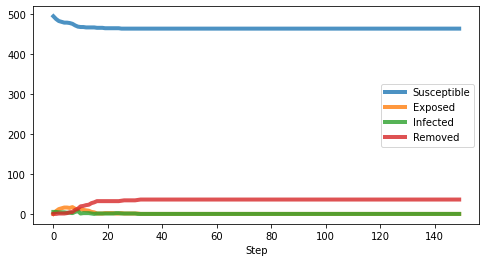

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


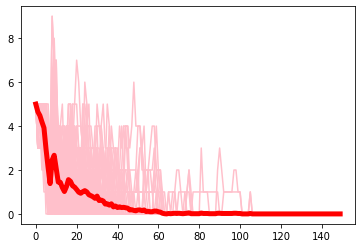

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)

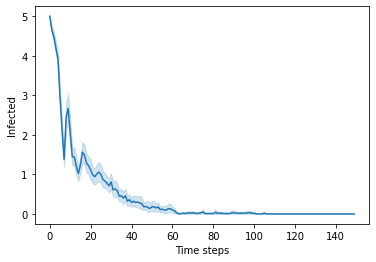

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_1 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
244                           6            6  0.375712
465                           6            6  0.385893
263                           6            6  0.163283
469                           3            5  0.244249
245                           3            6  0.496150
397                           2            5  0.109468
467                           1            6  0.089445
262                           1            5  0.169097
241                           1            6  0.056020
242                           1            6  0.408340
400                           1            5  0.121855
339                           0            6  0.011589
332                           0            8  0.061663
340                           0            6  0.225135
341                           0            5  0.031208
342                           0            6  0.518333
338                           0            6  0.008134
337                           0            6  0.084013
336                           0            6  1.028506
335                           0            5  0.025333

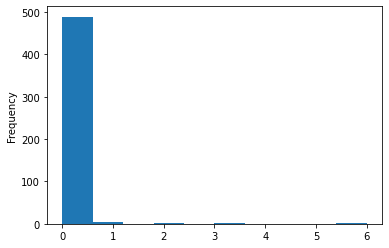

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

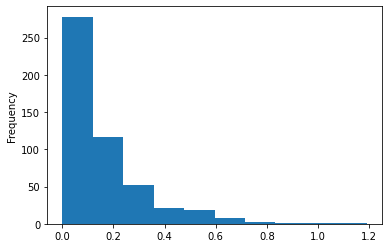

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _2

In [ ]:
#model set_up for strategy 2
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = random_groups(model.G, group_size)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0

      
    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      13.820733               36         1068                  5   
1      13.661175               33         1072                  5   
2      13.009718               39         1029                  6   
3      13.119974               60         1185                  7   
4      13.085205               47         1076                  9   
..           ...              ...          ...                ...   
95     12.881138               24          995                  5   
96     14.998311               59         1141                  5   
97     12.861303               42         1063                  5   
98     13.345893               37         1098                  5   
99     13.016144               52         1111                 10   

    max_2_trans  num_of_S  
0             5       461  
1             5       466  
2             6       453  
3             6       430  
4             6       446  
..          ...       ...  
95            5       466  
96            7       434  
97            6       455  
98            5       456  
99            6       441  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  13.33240112066269 0.058067333119756016
Average_found_positives:  40.16 1.9674482268289872
Average_total_tests:  1061.53 9.044798214856689
Average_max_outbreak_size:  5.93 0.12890760922913633
Average_max_2_trans: 5.85 0.11315047637120361
Average_number_of_uninfected: 453.55 2.089481836110174


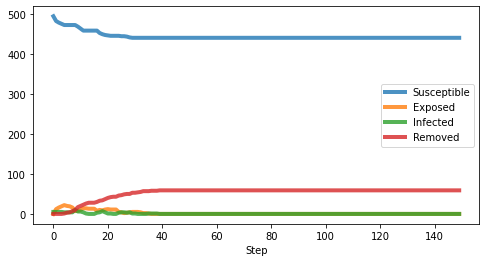

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


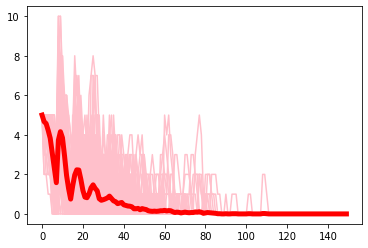

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


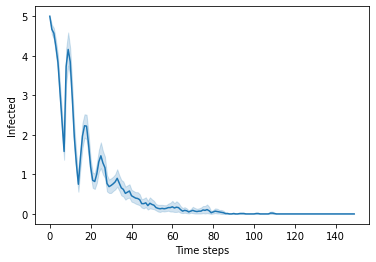

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_2 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
391                           6            6  0.504151
60                            6            6  0.378644
325                           5            6  0.206073
479                           5            5  0.348402
82                            4            8  0.169558
57                            3            6  0.399210
51                            3            6  0.338227
63                            3            6  0.150880
394                           2            5  0.241429
65                            2            6  0.451262
390                           2            6  0.606141
482                           2            7  0.299649
387                           2            4  0.858298
393                           1            5  0.167957
392                           1            6  0.374302
483                           1            6  0.072183
53                            1            7  0.019448
485                           1            6  0.332335
326                           1            5  0.240494
385                           1            6  0.020270

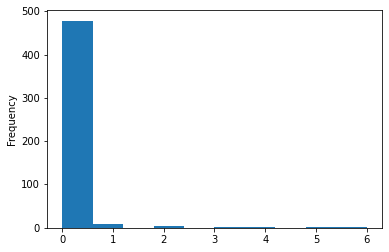

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

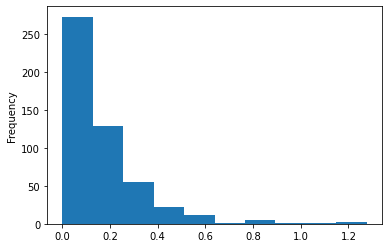

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _3

In [ ]:
#model set_up for strategy 3
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    random.shuffle(rand_groups)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      12.945238               34         1011                  5   
1      13.403150               36         1040                  5   
2      12.710790               36          962                  8   
3      15.208454               42         1023                  5   
4      13.129421               76         1145                 14   
..           ...              ...          ...                ...   
95     12.532478               24          915                  5   
96     13.243459               13          908                  5   
97     12.891815                7          913                  5   
98     13.479596               46         1013                  6   
99     12.929192               33         1011                  6   

    max_2_trans  num_of_S  
0             6       457  
1             4       459  
2             6       457  
3             6       453  
4             9       407  
..          ...       ...  
95            6       471  
96            5       481  
97            4       488  
98            6       447  
99            6       464  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  13.240639922618866 0.06440557016992338
Average_found_positives:  50.98 3.0587836758681672
Average_total_tests:  1056.51 10.970589654787812
Average_max_outbreak_size:  6.45 0.18497884126886438
Average_max_2_trans: 5.55 0.10576799462440747
Average_number_of_uninfected: 440.99 3.459418267205448


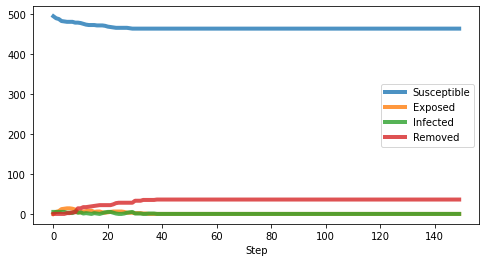

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


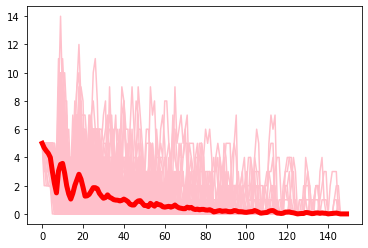

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_3 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
76                            6            6  0.271521
336                           6            6  0.496645
133                           3            7  0.091883
73                            3            6  0.196214
134                           2            7  0.135502
79                            2            6  0.068098
337                           1            8  0.166972
72                            1            6  0.098891
81                            1            6  0.021549
83                            1            6  0.171526
54                            1            6  0.034233
135                           1            5  0.086134
131                           1            5  0.043755
130                           1            6  0.132421
490                           1            7  0.107527
372                           0            6  0.064365
374                           0            5  0.187592
342                           0            4  0.001979
341                           0            6  0.006719
340                           0            6  0.001042

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

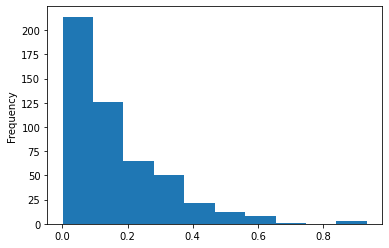

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _4

In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)
            else:
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      13.520925               28         1016                  5   
1      14.077591               49         1092                  5   
2      15.250639               17          926                  5   
3      14.110859               26          965                  5   
4      13.712222               29          976                  6   
..           ...              ...          ...                ...   
95     14.097251               53         1102                  7   
96     13.838861               32         1015                  5   
97     14.033894               19          946                  5   
98     13.592895               37         1040                  5   
99     14.172838               23          972                  5   

    max_2_trans  num_of_S  
0             6       467  
1             6       446  
2             6       478  
3             6       470  
4             9       463  
..          ...       ...  
95            6       442  
96            4       460  
97            7       478  
98            6       459  
99            5       468  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  14.116531202793121 0.06503094486123008
Average_found_positives:  34.36 1.9406090890139716
Average_total_tests:  1003.59 8.833282961548775
Average_max_outbreak_size:  5.82 0.16229415867305247
Average_max_2_trans: 5.55 0.103840398125336
Average_number_of_uninfected: 460.48 2.092192315937683


In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


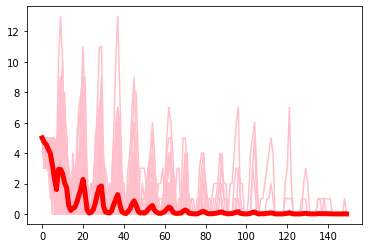

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_4 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
160                           5            6  0.701650
471                           4            6  0.537118
474                           4            6  0.055343
468                           3            6  0.327073
460                           3            6  0.128419
476                           2            7  0.346377
465                           1            6  0.080060
464                           1            6  0.700997
158                           1            6  0.505421
59                            1            5  0.473343
473                           1            6  0.161617
477                           1            6  0.417350
339                           0            6  0.199904
338                           0            6  0.492159
333                           0            6  0.282549
337                           0            7  0.123770
340                           0            6  0.145519
336                           0            6  0.047907
335                           0            5  0.165953
334                           0            6  0.268085

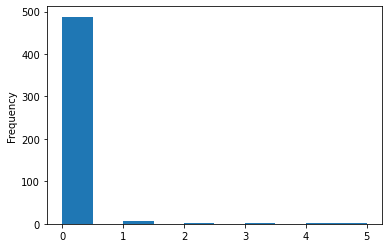

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

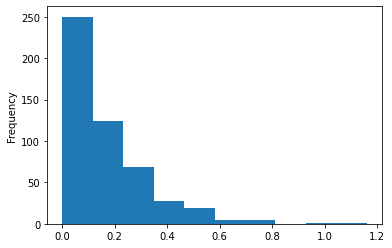

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(472, 30), (467, 37), (465, 37), (464, 45), (461, 46)]

In [ ]:
group_df

Group  Degree  Intra_C  \
28  [242, 246, 244, 245, 249, 247, 248, 253, 250, ...      61       20   
29  [255, 252, 254, 258, 256, 257, 261, 259, 260, ...      61       20   
32  [286, 284, 285, 289, 287, 288, 293, 290, 291, ...      61       20   
31  [273, 277, 275, 276, 280, 278, 279, 283, 281, ...      60       20   
7   [351, 349, 350, 354, 352, 353, 355, 356, 388, ...      61       19   
38  [371, 368, 369, 373, 370, 372, 376, 374, 375, ...      57       18   
21  [134, 135, 139, 137, 138, 142, 140, 141, 145, ...      60       19   
41  [415, 412, 414, 418, 416, 417, 421, 419, 420, ...      59       19   
33  [292, 294, 306, 304, 305, 309, 307, 308, 312, ...      61       18   
40  [395, 399, 397, 398, 403, 400, 401, 405, 402, ...      55       20   
14           [32, 30, 31, 35, 33, 34, 42, 40, 41, 45]      59       16   
0   [408, 406, 407, 212, 210, 211, 413, 411, 409, ...      58       18   
18           [73, 74, 87, 84, 85, 89, 86, 88, 92, 90]      61       17   
39  [377, 378, 382, 379, 381, 385, 383, 384, 396, ...      61       15   
1   [202, 199, 201, 200, 203, 392, 389, 390, 391, ...      63       16   
36  [334, 335, 339, 337, 338, 342, 340, 341, 346, ...      60       17   
35  [325, 322, 323, 327, 324, 326, 333, 331, 332, ...      63       15   
37  [344, 348, 345, 347, 364, 362, 363, 367, 365, ...      60       16   
20  [112, 110, 111, 116, 113, 114, 133, 131, 132, ...      61       15   
43  [432, 436, 434, 435, 449, 446, 448, 452, 450, ...      61       15   
30  [262, 263, 268, 265, 267, 272, 269, 270, 274, ...      58       16   
47  [129, 126, 128, 127, 130, 151, 149, 150, 152, ...      58       16   
49     [302, 299, 301, 300, 303, 38, 36, 37, 39, 266]      64       14   
24  [170, 172, 176, 174, 175, 179, 177, 178, 187, ...      60       15   
25  [186, 190, 188, 189, 206, 204, 205, 209, 207, ...      57       16   
10  [487, 490, 499, 497, 498, 360, 357, 359, 358, ...      58       13   
4   [103, 108, 105, 106, 107, 109, 118, 115, 117, ...      57       13   
26  [220, 217, 219, 223, 221, 222, 231, 229, 230, ...      53       14   
6   [194, 195, 298, 296, 297, 227, 224, 225, 226, ...      58       12   
5   [119, 120, 121, 124, 198, 196, 197, 193, 191, ...      60       10   
45  [462, 463, 467, 465, 466, 470, 468, 469, 479, ...      60       17   
44  [455, 453, 454, 458, 456, 457, 461, 459, 460, ...      65       21   
48  [159, 157, 158, 160, 162, 183, 180, 182, 181, ...      59       16   
9   [125, 476, 474, 475, 485, 483, 484, 489, 486, ...      61       13   
16           [53, 57, 55, 56, 61, 58, 59, 63, 60, 62]      59       19   
23  [164, 161, 163, 167, 165, 166, 171, 168, 169, ...      60       19   
8   [387, 215, 213, 214, 216, 218, 473, 471, 472, ...      58       11   
46  [478, 482, 480, 481, 494, 491, 492, 496, 493, ...      60       16   
15           [43, 44, 48, 46, 47, 51, 49, 50, 54, 52]      62       21   
22  [144, 148, 146, 147, 156, 154, 155, 330, 328, ...      59       12   
17           [66, 64, 65, 69, 67, 68, 72, 70, 71, 75]      62       22   
34  [311, 315, 313, 314, 318, 316, 317, 321, 319, ...      62       22   
13           [19, 23, 21, 22, 26, 24, 25, 29, 27, 28]      63       21   
3          [78, 76, 77, 82, 79, 81, 80, 83, 104, 102]      61       18   
11                    [2, 0, 1, 5, 3, 4, 8, 6, 7, 11]      59       21   
19         [91, 95, 93, 94, 98, 96, 97, 101, 99, 100]      59       21   
42  [422, 423, 427, 425, 426, 430, 428, 429, 433, ...      62       20   
2   [440, 437, 439, 438, 441, 445, 442, 443, 444, ...      61       20   
12            [9, 10, 14, 12, 13, 17, 15, 16, 20, 18]      61       20   
27  [232, 233, 237, 235, 236, 241, 238, 239, 243, ...      61       20   

       order  record  flag  
28  0.000003      18     1  
29  0.000003      18     1  
32  0.000003      18     1  
31  0.000003      18     1  
7   0.000003      18     1  
38  0.000003      18     1  
21  0.000006      17     0  
41  0.000006      17     0  
33  0.000006

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
160                           5            6  0.701650
471                           4            6  0.537118
474                           4            6  0.055343
468                           3            6  0.327073
460                           3            6  0.128419
476                           2            7  0.346377
465                           1            6  0.080060
464                           1            6  0.700997
158                           1            6  0.505421
59                            1            5  0.473343
473                           1            6  0.161617
477                           1            6  0.417350
339                           0            6  0.199904
338                           0            6  0.492159
333                           0            6  0.282549
337                           0            7  0.123770
340                           0            6  0.145519
336                           0            6  0.047907
335                           0            5  0.165953
334                           0            6  0.268085

##Testing Strategy_4_high_2


In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            else:
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)              
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      13.999425               21          916                  5   
1      14.273971               39          976                  8   
2      14.271904               34          946                  5   
3      16.030854               33          926                  7   
4      14.194669               31          965                  5   
..           ...              ...          ...                ...   
95     15.469620               22          926                  5   
96     13.913163               24          936                  5   
97     13.807448               32          966                  5   
98     13.873774               34          936                  7   
99     13.618609               24          966                  6   

    max_2_trans  num_of_S  
0             6       478  
1             6       459  
2             6       460  
3             7       461  
4             6       466  
..          ...       ...  
95            5       474  
96            6       474  
97            6       463  
98            7       461  
99            4       475  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  14.293609228134155 0.0619873428898276
Average_found_positives:  26.66 1.1569046126748233
Average_total_tests:  942.4 3.137456989926135
Average_max_outbreak_size:  5.63 0.1284365975723415
Average_max_2_trans: 5.62 0.11261806375012973
Average_number_of_uninfected: 468.74 1.2753783356282553


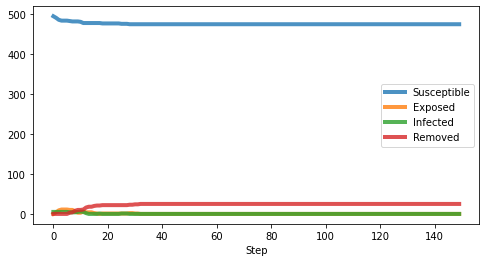

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


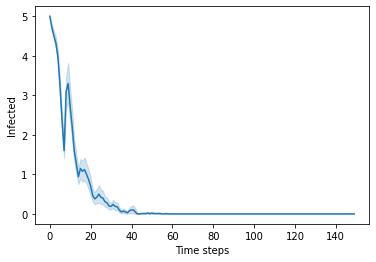

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_5 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
48                            4            5  0.249763
424                           4            6  0.173862
427                           3            7  0.245747
499                           2            7  0.034935
423                           2            6  0.124554
303                           2            5  0.109943
205                           1            6  0.021204
421                           1            6  0.125632
305                           1            6  0.273073
331                           0            6  0.092748
329                           0            6  0.049147
330                           0            6  0.081552
1                             0            6  0.079907
328                           0            6  0.100500
333                           0            6  0.294592
334                           0            6  0.174869
335                           0            6  0.137732
336                           0            6  0.071696
337                           0            6  0.329309
338                           0            7  0.137981

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(419, 15), (305, 17), (303, 27), (306, 29), (304, 31)]

In [ ]:
group_df

Group  Degree  Intra_C  \
23  [135, 139, 137, 138, 142, 140, 141, 145, 143, ...      61       23   
10  [418, 423, 420, 421, 422, 425, 445, 442, 443, ...      61       13   
16           [43, 44, 48, 46, 47, 51, 49, 50, 54, 52]      63       19   
40  [394, 395, 399, 397, 398, 402, 400, 401, 405, ...      65       21   
13                 [3, 4, 8, 6, 7, 11, 9, 10, 14, 12]      64       21   
31  [241, 242, 246, 244, 245, 249, 247, 248, 252, ...      64       21   
38  [361, 365, 363, 364, 369, 366, 367, 371, 368, ...      62       21   
46  [493, 494, 498, 496, 497, 157, 155, 156, 158, ...      64       15   
36  [323, 320, 321, 338, 335, 336, 341, 339, 340, ...      60       13   
8         [18, 19, 331, 329, 330, 72, 69, 71, 70, 73]      60       13   
49  [314, 337, 334, 332, 333, 424, 426, 429, 427, ...      61       12   
29  [216, 225, 222, 224, 228, 226, 227, 231, 229, ...      59       19   
11  [444, 446, 448, 450, 478, 476, 477, 482, 479, ...      62       13   
18           [79, 77, 78, 82, 80, 81, 85, 83, 84, 88]      62       20   
42  [435, 433, 434, 438, 436, 437, 441, 439, 440, ...      62       20   
28  [206, 207, 211, 209, 210, 214, 212, 213, 217, ...      58       17   
44  [491, 466, 464, 465, 469, 467, 468, 472, 470, ...      61       20   
6        [62, 67, 64, 66, 65, 68, 119, 117, 118, 122]      59       14   
30  [234, 232, 233, 238, 235, 236, 240, 237, 239, ...      60       20   
33  [278, 276, 277, 281, 279, 280, 284, 282, 283, ...      60       20   
25  [159, 161, 165, 163, 164, 168, 166, 167, 258, ...      60       16   
34  [285, 286, 290, 287, 289, 293, 291, 292, 296, ...      62       19   
22  [125, 126, 130, 128, 129, 133, 131, 132, 136, ...      59       20   
45  [475, 473, 474, 486, 484, 485, 489, 487, 488, ...      61       14   
41  [404, 413, 410, 412, 416, 414, 415, 432, 430, ...      57       13   
43  [449, 451, 455, 453, 454, 458, 456, 457, 492, ...      60       17   
27  [272, 269, 271, 196, 194, 195, 199, 197, 198, ...      54       14   
9       [383, 381, 382, 29, 26, 28, 27, 30, 419, 417]      62       13   
39  [375, 372, 373, 377, 374, 376, 380, 378, 379, ...      58       19   
17           [53, 57, 55, 56, 60, 58, 59, 76, 74, 75]      61       16   
12   [480, 483, 300, 299, 297, 298, 328, 326, 327, 5]      62       11   
3   [386, 384, 385, 387, 389, 388, 391, 393, 390, ...      57       19   
15           [36, 34, 35, 40, 37, 38, 42, 39, 41, 45]      58       18   
26  [257, 181, 179, 180, 185, 182, 183, 187, 184, ...      58       18   
20   [97, 101, 99, 100, 104, 102, 103, 107, 105, 106]      60       21   
37  [342, 343, 348, 345, 346, 359, 356, 358, 362, ...      64       14   
1   [303, 301, 302, 304, 305, 91, 309, 308, 306, 307]      54       19   
14           [13, 23, 20, 21, 25, 22, 24, 33, 31, 32]      54       14   
2   [350, 347, 349, 351, 353, 192, 352, 357, 354, ...      56       18   
47  [220, 218, 219, 221, 223, 408, 406, 407, 409, ...      62       16   
21  [110, 108, 109, 114, 111, 112, 116, 113, 115, ...      58       17   
48  [462, 459, 461, 460, 463, 173, 175, 178, 176, ...      53       14   
0   [171, 169, 170, 172, 174, 268, 265, 266, 267, ...      62       14   
24  [148, 146, 147, 151, 149, 150, 154, 152, 153, ...      63       21   
4   [325, 322, 324, 202, 200, 201, 205, 203, 204, ...      62       16   
32  [251, 261, 259, 260, 264, 262, 263, 275, 273, ...      58       15   
7     [120, 121, 123, 124, 255, 253, 254, 17, 15, 16]      61       11   
5          [2, 0, 1, 191, 188, 189, 190, 193, 63, 61]      63       11   
35  [295, 312, 310, 311, 316, 313, 315, 319, 317, ...      58       16   
19           [86, 87, 92, 89, 90, 95, 93, 94, 98, 96]      55       17   

       order  record  flag  
23  0.000004      18     1  
10  0.000004      24     1  
16  0.000004      24     1  
40  0.000004      18     1  
13  0.000004      18     1  
31  0.000004      18     1  
38  0.000007      17     0  
46  0.000007      19     0  
36  0.000007

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
48                            4            5  0.249763
424                           4            6  0.173862
427                           3            7  0.245747
499                           2            7  0.034935
423                           2            6  0.124554
303                           2            5  0.109943
205                           1            6  0.021204
421                           1            6  0.125632
305                           1            6  0.273073
331                           0            6  0.092748
329                           0            6  0.049147
330                           0            6  0.081552
1                             0            6  0.079907
328                           0            6  0.100500
333                           0            6  0.294592
334                           0            6  0.174869
335                           0            6  0.137732
336                           0            6  0.071696
337                           0            6  0.329309
338                           0            7  0.137981

##Vis

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_5['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_5])
temp = temp.reset_index()

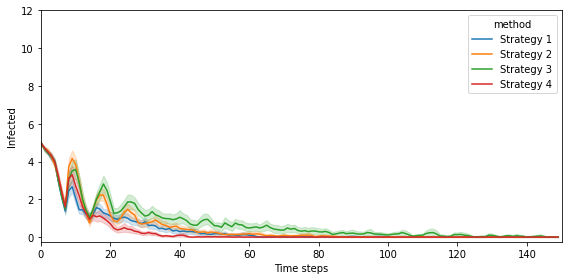

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 150)
plt.ylim(top = 12)
plt.tight_layout()

# Stochastic Bloack model (SBM)

In [ ]:
community_sizes = [10 for i in range(50)]
community_probs = [[0.15 if i==k else 0.01 for i in range(50)] for k in range(50)]
G_temp = nx.stochastic_block_model(community_sizes, community_probs, seed = 42)
[G_temp.add_edge(i, random.randint(0,499)) for i in list(nx.isolates(G_temp))]
G = nx.convert_node_labels_to_integers(G_temp)

print("# of nodes: ", G.number_of_nodes())
print("Average degree: ", 2*G.number_of_edges()/G.number_of_nodes())
print(list(nx.isolates(G)))

# of nodes:  500
Average degree:  6.584
[]


In [ ]:
def network_gen():
  community_sizes = [10 for i in range(50)]
  community_probs = [[0.15 if i==k else 0.01 for i in range(50)] for k in range(50)]
  G_temp = nx.stochastic_block_model(community_sizes, community_probs, seed = 42)
  [G_temp.add_edge(i, random.randint(0,499)) for i in list(nx.isolates(G_temp))]
  G = nx.convert_node_labels_to_integers(G_temp)
  return G

##Testing Strategy _0

In [ ]:
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, avg_node_degree=6, data_G = network_gen())
for i in range(steps):
    model.step()
print (time.time()-st)
#agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:30])


2.6626715660095215
      Susceptible  Exposed  Infected  Removed
Step                                         
0             495        0         5        0
1             491        4         5        0
2             487        8         5        0
3             483       12         5        0
4             479       16         5        0
5             476       19         5        0
6             475       20         5        0
7             475       20         5        0
8             471       20         7        2
9             466       21         9        4
10            459       24        11        6
11            450       29        14        7
12            445       31        14       10
13            439       36        10       15
14            434       41         9       16
15            430       41         9       20
16            430       36        14       20
17            426       33        18       23
18            418       32        22       28
19            4

In [ ]:
print("max_outbreak_size: ", get_column_data(model).Infected.max())
print("number_of_uninfected:",get_column_data(model).Susceptible.min())

max_outbreak_size:  114
number_of_uninfected: 21


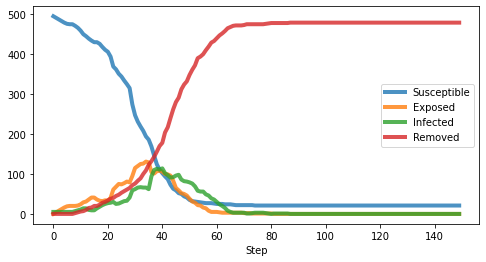

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
16                           12           12  0.229836
88                            8           12  0.309050
188                           8           10  0.197250
468                           8           12  0.124166
309                           7           14  0.181469
341                           7            8  0.196751
194                           6            9  0.542249
3                             6            8  0.389952
53                            6            8  0.308957
79                            6            9  0.363562
408                           5            7  0.864402
467                           5           10  0.591331
161                           5           10  0.623413
490                           5            9  0.199209
47                            5            8  0.399679
436                           5            6  0.189003
273                           5            8  0.271725
266                           4            7  0.076468
29                            4           12  0.315327
35                            4           11  0.263763

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _1

In [ ]:
#model set_up for strategy 1
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    ind = random.sample(range(1,pop+1), pop)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0

    if np.mod(pop, capacity) != 0:
        null_tail = [0] * (capacity - np.mod(pop, capacity))
        finish_flag = int(np.ceil(pop/capacity))
        ind.extend(null_tail)
        t_order = np.array(ind).reshape(finish_flag, capacity)
    else:
      finish_flag = int(pop/capacity)
      t_order = np.array(ind).reshape(finish_flag, capacity)
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            if test_key < finish_flag:
                temp = model.datacollector.get_agent_vars_dataframe()
                temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
                infection_matrix = csr_matrix(temp.values)
                for v in t_order[test_key]:
                    if v == 0:
                        test_key = 0
                        break
                    n_tests += 1
                    if infection_matrix[v-1, i] == 2:
                        model.schedule.agents[v-1].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v,i))) 
                    if infection_matrix[v-1, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v-1].exposed_time) > 4:
                            model.schedule.agents[v-1].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v,i)))
                test_key += 1
                if test_key == finish_flag:
                    test_key = 0
                
            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()

    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      13.292914               50        10350                  5   
1      13.589876               84        10350                  8   
2      12.956126              119        10350                  6   
3      13.829676              122        10350                  8   
4      14.834183               10        10350                  5   
..           ...              ...          ...                ...   
95     13.800615               85        10350                  6   
96     14.944199               51        10350                  5   
97     13.739659               20        10350                  5   
98     13.206210               96        10350                  6   
99     13.927804              187        10350                 12   

    max_2_trans  num_of_S  
0             8       435  
1             9       395  
2             9       357  
3            11       351  
4             3       485  
..          ...       ...  
95            6       398  
96            9       442  
97            7       474  
98            9       386  
99            9       270  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  13.696178452968597 0.06876020016028861
Average_found_positives:  116.02 6.436370455968538
Average_total_tests:  10350.0 0.0
Average_max_outbreak_size:  7.48 0.2900644303208749
Average_max_2_trans: 8.3 0.21719050893562822
Average_number_of_uninfected: 358.73 7.861231494241892


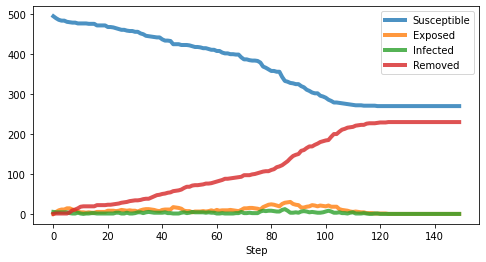

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


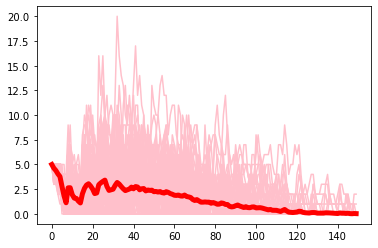

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)

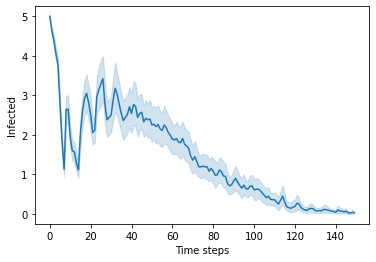

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_1 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
359                           9           12  0.262729
356                           7            8  0.207462
357                           7            9  0.307602
259                           7           11  0.421274
13                            7            9  0.654547
250                           6           10  0.653012
178                           6           12  0.574032
38                            6            7  0.731215
273                           6            8  0.193547
438                           6            9  0.147656
343                           6            8  0.365432
485                           6            7  0.299446
418                           5            5  0.284287
93                            5            9  0.394231
207                           5           19  0.244513
452                           5            9  0.077849
214                           5            8  0.176479
188                           5           10  0.102720
210                           5            9  0.334264
384                           4            6  0.816244

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

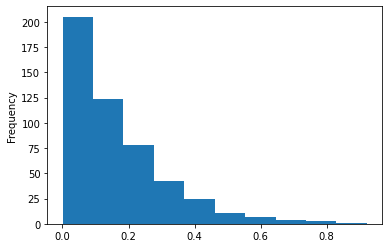

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _2

In [ ]:
#model set_up for strategy 2
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = random_groups(model.G, group_size)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0

      
    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      15.530121              154         1425                 10   
1      13.476530              245         1630                 16   
2      13.617953               87         1182                  6   
3      13.306315              196         1521                  7   
4      13.424952              236         1656                 12   
..           ...              ...          ...                ...   
95     13.576818              216         1637                  7   
96     13.513423              277         1760                 14   
97     13.523896              209         1659                  9   
98     13.573819              109         1287                  8   
99     13.480562              258         1740                  9   

    max_2_trans  num_of_S  
0             8       324  
1            10       224  
2             7       398  
3             8       289  
4             9       243  
..          ...       ...  
95            8       260  
96            9       198  
97           10       249  
98           11       369  
99            7       217  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  13.66910849571228 0.059512707941808095
Average_found_positives:  176.44 7.894152291667572
Average_total_tests:  1485.2 25.054199833419734
Average_max_outbreak_size:  9.25 0.3485540115819914
Average_max_2_trans: 8.91 0.21371887510408993
Average_number_of_uninfected: 304.87 8.517061367833058


In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_2 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
457                           7           12  0.932188
34                            7           10  0.577073
216                           7            9  0.326479
356                           6            8  0.490074
388                           6            9  0.311458
452                           6            9  0.616519
383                           5            8  0.337292
494                           5            8  0.308783
76                            5            9  0.261845
13                            5            9  0.460148
265                           5           10  0.170042
282                           4            7  0.475945
124                           4            8  0.119257
464                           4            7  0.438738
435                           4            7  0.241637
232                           4            6  0.635982
21                            4            7  0.210959
210                           4            9  0.153067
207                           4           19  0.189368
125                           3            7  0.213340

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

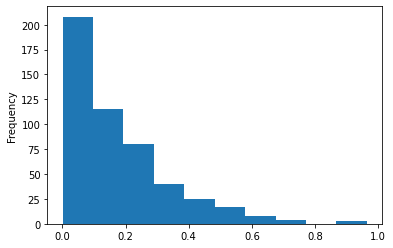

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _3

In [ ]:
#model set_up for strategy 3
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    random.shuffle(rand_groups)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      13.784966              261         1706                 16   
1      13.780743              216         1661                  7   
2      13.535604              294         1899                 16   
3      15.369200              123         1389                 11   
4      13.753237              271         1769                 18   
..           ...              ...          ...                ...   
95     13.798555              193         1598                 13   
96     13.160778              281         1737                 15   
97     15.960614              273         1713                 12   
98     13.330078              275         1699                 17   
99     14.120890              271         1834                 16   

    max_2_trans  num_of_S  
0            10       199  
1            10       256  
2             8       182  
3            10       368  
4            11       203  
..          ...       ...  
95            8       289  
96            7       196  
97            8       200  
98           11       183  
99            7       191  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  13.831357016563416 0.06274136774448832
Average_found_positives:  241.35 5.8300055442910725
Average_total_tests:  1705.86 17.717559742592183
Average_max_outbreak_size:  12.56 0.38146977851356967
Average_max_2_trans: 9.29 0.1887197698047333
Average_number_of_uninfected: 231.75 6.325790963439379


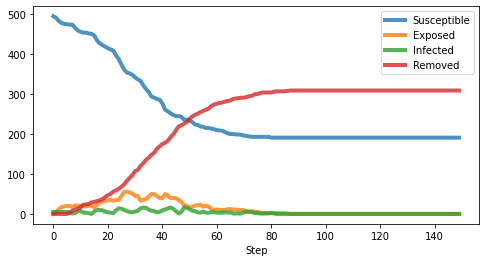

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


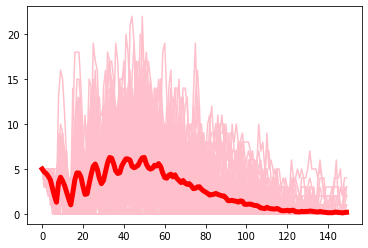

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


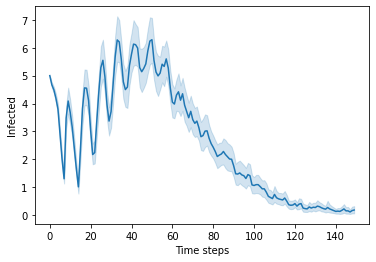

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_3 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
171                           7           10  0.359334
448                           7           10  0.464092
338                           7            9  0.606098
366                           7            9  0.253522
273                           7            8  0.749952
61                            7           10  1.121296
295                           6           10  0.215191
99                            6            7  0.376353
2                             6            8  0.225433
259                           6           11  0.150548
332                           6            7  0.191059
3                             6            8  0.171104
309                           5           14  0.338266
18                            5            7  0.404403
358                           5           10  0.148420
359                           5           12  0.192166
424                           5            7  0.281140
103                           5           12  0.117677
125                           5            7  0.539632
71                            4            7  0.221941

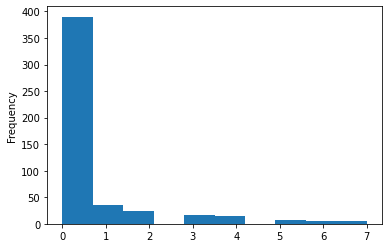

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

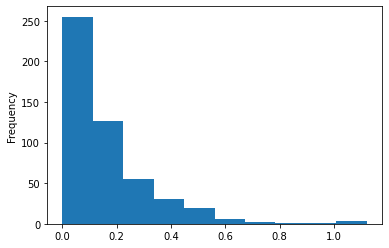

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _4

In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)
            else:
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      16.561270              237         1902                  8   
1      14.994933               46         1096                  6   
2      15.810661              253         1961                 13   
3      16.201731              296         2135                 13   
4      14.627053              180         1645                  9   
..           ...              ...          ...                ...   
95     16.167231              283         2077                 15   
96     15.623173               25          955                  5   
97     16.017809              264         2006                 11   
98     14.963498              218         1910                  8   
99     16.199133              264         1901                 10   

    max_2_trans  num_of_S  
0             9       245  
1             5       446  
2            11       224  
3            10       183  
4            10       301  
..          ...       ...  
95            9       196  
96           10       472  
97            8       213  
98            9       252  
99            8       220  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  15.490831904411316 0.06989635551100983
Average_found_positives:  178.03 8.318222117250729
Average_total_tests:  1635.25 36.981246612439946
Average_max_outbreak_size:  9.24 0.352514775104061
Average_max_2_trans: 8.67 0.2005321204025213
Average_number_of_uninfected: 303.44 9.018626292402862


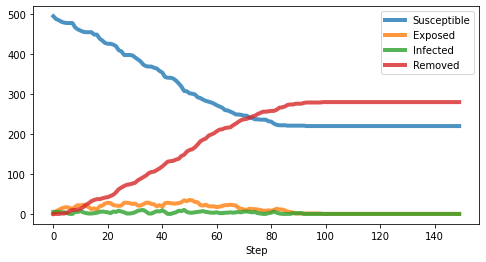

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


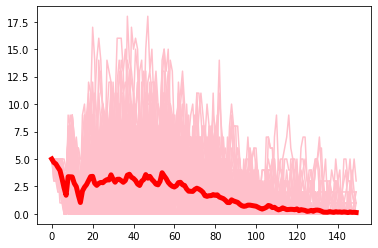

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


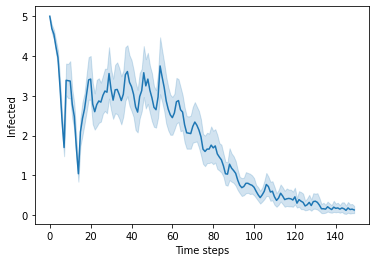

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_4 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
103                           8           12  0.477214
57                            8           10  0.649113
29                            7           12  0.224038
481                           6            7  0.659685
280                           6            9  0.212742
134                           6            9  0.270248
342                           6            6  0.177852
480                           6            8  0.266943
319                           5            9  0.257247
212                           5            8  0.195731
208                           5            9  0.270133
341                           5            8  0.467186
284                           5            6  0.752394
309                           5           14  0.202444
165                           5            7  0.566561
262                           4            6  0.104526
75                            4            8  0.600414
216                           4            9  0.361717
63                            4           11  0.469140
327                           4           11  0.504434

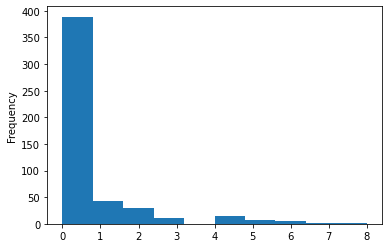

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

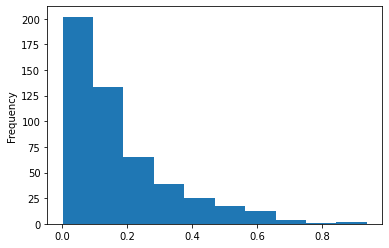

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(466, 88), (64, 91), (88, 91), (362, 92), (45, 98)]

In [ ]:
group_df

Group  Degree  Intra_C  \
35   [202, 90, 91, 125, 323, 196, 275, 261, 389, 104]      60        8   
43  [430, 253, 256, 342, 346, 335, 336, 382, 384, ...      68        7   
6    [381, 388, 410, 136, 167, 428, 429, 449, 58, 87]      72        9   
33       [195, 68, 171, 170, 177, 63, 65, 69, 94, 76]      70        8   
45  [197, 231, 230, 245, 443, 116, 123, 140, 144, ...      68       11   
46        [164, 470, 11, 17, 27, 61, 64, 84, 488, 22]      62        7   
3    [347, 421, 424, 18, 38, 362, 360, 361, 365, 438]      65       10   
13     [162, 178, 281, 292, 0, 2, 128, 251, 397, 310]      58        6   
40  [181, 182, 183, 185, 221, 233, 333, 228, 309, ...      65        5   
15  [263, 372, 290, 294, 211, 300, 266, 406, 220, ...      73        7   
38  [258, 131, 222, 149, 152, 232, 236, 150, 155, ...      70        7   
27            [271, 499, 451, 7, 260, 3, 6, 8, 9, 10]      66        9   
4      [351, 418, 411, 412, 398, 16, 98, 417, 83, 86]      62       10   
1   [317, 108, 111, 350, 67, 132, 356, 358, 400, 403]      66        9   
31   [203, 462, 466, 467, 468, 29, 134, 190, 193, 31]      70       11   
25  [423, 39, 172, 440, 442, 444, 446, 445, 447, 476]      62        8   
17  [318, 376, 229, 240, 268, 288, 255, 312, 319, 55]      57        8   
0     [303, 458, 345, 391, 394, 492, 495, 28, 20, 21]      65       10   
24  [330, 332, 331, 334, 392, 393, 396, 399, 422, ...      65        8   
16  [385, 225, 227, 212, 216, 311, 163, 314, 304, ...      56        8   
9   [461, 469, 485, 363, 368, 486, 489, 494, 273, ...      66        9   
42  [353, 297, 299, 250, 252, 254, 287, 349, 439, ...      59        8   
11  [226, 173, 174, 106, 110, 119, 112, 114, 113, ...      68        9   
10   [93, 248, 137, 246, 165, 168, 243, 160, 166, 96]      55        8   
2   [327, 352, 354, 145, 431, 329, 407, 338, 204, ...      67       10   
22      [402, 414, 437, 435, 14, 57, 324, 4, 35, 374]      58        7   
44  [315, 316, 390, 359, 405, 409, 487, 415, 122, ...      59        9   
12   [154, 23, 26, 184, 188, 187, 189, 115, 117, 118]      53        7   
37  [474, 151, 200, 383, 477, 120, 146, 143, 257, ...      54        7   
19   [272, 276, 277, 43, 45, 373, 482, 434, 441, 284]      51        8   
8    [432, 24, 54, 450, 219, 241, 459, 471, 473, 478]      67        9   
49     [59, 60, 62, 66, 484, 491, 153, 387, 380, 386]      69       10   
36  [341, 207, 208, 161, 194, 198, 199, 109, 269, ...      65        7   
20   [285, 289, 479, 321, 326, 337, 40, 49, 301, 302]      74        8   
41  [355, 280, 426, 308, 357, 235, 339, 237, 270, ...      75        7   
34       [88, 97, 147, 70, 77, 74, 78, 103, 107, 201]      72        7   
47    [179, 25, 279, 102, 105, 490, 142, 169, 13, 50]      79        8   
14  [344, 283, 322, 340, 395, 205, 278, 298, 328, ...      67        7   
30   [47, 42, 296, 210, 215, 348, 367, 124, 209, 192]      64        8   
26  [282, 286, 453, 480, 481, 483, 454, 456, 457, 36]      67        8   
39  [234, 175, 267, 213, 218, 186, 244, 242, 249, ...      66        8   
5   [366, 416, 463, 465, 377, 79, 214, 497, 156, 157]      76        9   
23  [375, 370, 378, 379, 498, 325, 82, 133, 433, 452]      61        8   
32      [369, 51, 52, 99, 217, 224, 305, 44, 48, 191]      73        7   
29    [89, 53, 135, 138, 139, 130, 176, 238, 239, 41]      68        7   
21  [306, 307, 413, 493, 419, 56, 127, 313, 427, 401]      67        7   
7        [408, 460, 436, 32, 46, 448, 1, 5, 464, 472]      75        9   
48       [71, 75, 420, 12, 15, 475, 92, 95, 455, 496]      69        8   
18   [129, 264, 265, 291, 293, 295, 364, 320, 72, 73]      69        8   
28         [19, 100, 101, 30, 33, 34, 37, 80, 81, 85]      79        8   

       order  record  flag  
35  0.003736      18     1  
43  0.003376      18     1  
6   0.003066      18     1  
33  0.003012      18     1  
45  0.002709      18     1  
46  0.002513      18     1  
3   0.003830      17     0  
13  0.002687      17     0  
40  0.002523

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
103                           8           12  0.477214
57                            8           10  0.649113
29                            7           12  0.224038
481                           6            7  0.659685
280                           6            9  0.212742
134                           6            9  0.270248
342                           6            6  0.177852
480                           6            8  0.266943
319                           5            9  0.257247
212                           5            8  0.195731
208                           5            9  0.270133
341                           5            8  0.467186
284                           5            6  0.752394
309                           5           14  0.202444
165                           5            7  0.566561
262                           4            6  0.104526
75                            4            8  0.600414
216                           4            9  0.361717
63                            4           11  0.469140
327                           4           11  0.504434

##Testing Strategy_4_high_2


In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            else:
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)              
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      15.217294              211         1526                 19   
1      14.948053               76         1150                  6   
2      14.920839              191         1507                  9   
3      16.003922              271         1668                 21   
4      13.994623               42          975                  5   
..           ...              ...          ...                ...   
95     15.629781              224         1615                 11   
96     16.235115              251         1729                 14   
97     14.266060               15          916                  5   
98     15.638454              192         1545                 11   
99     17.515124              239         1718                  9   

    max_2_trans  num_of_S  
0             9       233  
1             8       415  
2             9       281  
3             8       162  
4             8       451  
..          ...       ...  
95           10       234  
96            7       194  
97            6       482  
98            8       264  
99            9       214  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  15.239210014343263 0.08179351469406589
Average_found_positives:  134.95 8.908381877578423
Average_total_tests:  1318.72 29.268320102393336
Average_max_outbreak_size:  9.3 0.50761872274057
Average_max_2_trans: 8.39 0.2681379864882628
Average_number_of_uninfected: 339.57 10.839753389046889


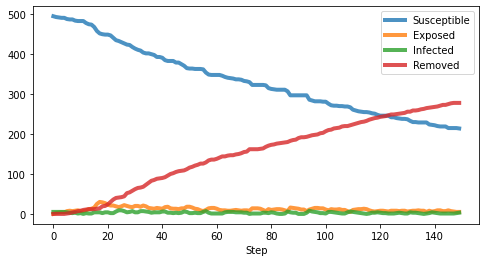

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_5 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
479                           9           13  0.266989
195                           9           13  0.138533
174                           8            9  0.650878
62                            8           13  0.156346
450                           8           13  0.458156
310                           7           11  1.010787
161                           6           10  0.325308
214                           6            8  0.360410
25                            5            7  0.296496
191                           5           10  0.477936
468                           5           12  0.402900
390                           5           11  0.330692
347                           5            6  0.463330
203                           5           10  0.111255
440                           4           11  0.584881
103                           4           12  0.303680
115                           4           11  0.470633
220                           4           10  0.332727
484                           4            8  0.291104
414                           4            5  0.116770

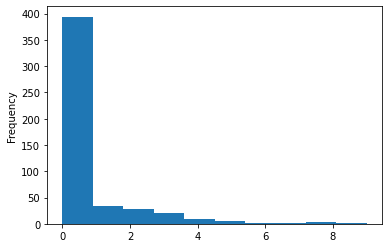

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

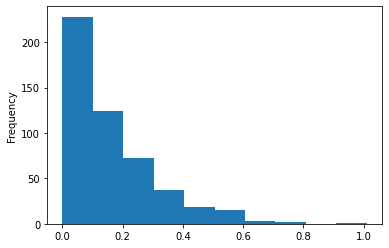

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(439, 144), (115, 145), (97, 145), (99, 146), (355, 149)]

In [ ]:
group_df

Group  Degree  Intra_C  \
5      [396, 399, 422, 425, 400, 403, 30, 33, 34, 37]      71        9   
30    [171, 170, 177, 115, 117, 118, 162, 76, 88, 97]      64        8   
43  [203, 259, 315, 443, 116, 123, 140, 144, 148, ...      70        7   
16     [319, 55, 129, 248, 374, 324, 4, 35, 349, 439]      55        8   
32   [275, 261, 389, 93, 98, 232, 236, 149, 152, 392]      62        8   
2   [327, 352, 354, 145, 431, 329, 407, 338, 204, ...      67       10   
28    [135, 138, 139, 41, 47, 42, 296, 102, 105, 103]      64        8   
24              [21, 27, 61, 80, 81, 85, 89, 3, 6, 8]      67        7   
10      [64, 84, 70, 77, 106, 110, 119, 112, 114, 96]      69        9   
45       [13, 50, 71, 75, 401, 402, 10, 19, 100, 101]      73       10   
0    [262, 263, 372, 290, 294, 295, 364, 320, 72, 73]      71       10   
33  [393, 104, 341, 207, 208, 184, 188, 187, 189, ...      66        7   
42    [79, 214, 499, 451, 7, 260, 415, 122, 126, 192]      52        8   
31   [147, 161, 194, 198, 199, 90, 91, 125, 323, 196]      62        6   
40  [458, 345, 391, 280, 426, 308, 357, 301, 302, ...      74        9   
41  [307, 304, 371, 318, 376, 351, 418, 411, 412, ...      66        8   
17  [404, 430, 250, 252, 254, 287, 331, 334, 497, ...      59        7   
46       [420, 12, 15, 435, 14, 57, 432, 24, 54, 450]      67        7   
36  [181, 182, 183, 197, 231, 230, 245, 228, 309, ...      66        5   
38  [218, 253, 256, 316, 390, 444, 446, 247, 353, ...      59        7   
22   [175, 267, 379, 498, 394, 492, 449, 58, 87, 454]      69        7   
9   [457, 36, 271, 473, 478, 486, 489, 494, 273, 343]      76        9   
1   [317, 108, 111, 350, 67, 132, 359, 405, 409, 487]      63        9   
20  [328, 330, 332, 311, 163, 314, 313, 427, 325, 82]      52        8   
35  [257, 121, 258, 131, 222, 137, 246, 165, 168, ...      60        7   
48  [201, 202, 205, 278, 484, 491, 153, 387, 380, ...      66        9   
25      [9, 130, 176, 238, 239, 16, 495, 59, 60, 210]      72        8   
44      [488, 22, 179, 63, 65, 69, 94, 490, 142, 169]      74        9   
8        [417, 83, 86, 440, 442, 448, 1, 5, 464, 472]      76       11   
49   [455, 496, 475, 92, 95, 461, 469, 485, 363, 368]      57        8   
11     [226, 173, 174, 178, 281, 292, 0, 2, 113, 158]      62        8   
6    [398, 25, 279, 414, 437, 413, 493, 419, 56, 127]      71        9   
15  [216, 243, 160, 166, 229, 240, 268, 288, 255, ...      50        6   
23     [456, 453, 480, 481, 483, 470, 11, 17, 28, 20]      72        7   
27      [468, 29, 134, 190, 193, 31, 369, 51, 52, 53]      64        7   
14  [220, 223, 385, 225, 227, 186, 244, 242, 249, ...      58        9   
4   [381, 388, 410, 136, 167, 382, 384, 476, 282, ...      61        9   
7     [408, 460, 436, 32, 46, 423, 39, 172, 428, 429]      65        9   
34  [269, 141, 474, 151, 200, 383, 477, 120, 146, ...      52        7   
3    [347, 421, 424, 18, 38, 362, 360, 361, 365, 438]      65       10   
47   [219, 241, 445, 447, 44, 48, 191, 195, 459, 471]      71        8   
13  [310, 344, 283, 322, 340, 395, 150, 155, 159, ...      73        8   
29     [107, 62, 66, 185, 221, 99, 217, 224, 305, 68]      75        7   
12   [154, 23, 26, 235, 339, 237, 270, 128, 251, 397]      47        6   
39  [299, 342, 346, 356, 358, 264, 265, 291, 293, ...      76        7   
21  [133, 433, 452, 366, 416, 463, 465, 370, 378, ...      75        7   
26   [215, 348, 367, 74, 78, 124, 209, 462, 466, 467]      82        9   
19   [284, 285, 289, 479, 321, 326, 337, 40, 49, 298]      72        9   
37  [355, 211, 300, 266, 406, 233, 333, 335, 336, ...      82        7   
18   [157, 272, 276, 277, 43, 45, 373, 482, 434, 441]      50        8   

       order  record  flag  
5   0.001164      17     1  
30  0.001161      19     1  
43  0.001159      18     1  
16  0.001156      17     1  
32  0.001133      19     1  
2   0.001955      18     1  
28  0.002240      17     0  
24  0.002221      17     0  
10  0.002641

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
479                           9           13  0.266989
195                           9           13  0.138533
174                           8            9  0.650878
62                            8           13  0.156346
450                           8           13  0.458156
310                           7           11  1.010787
161                           6           10  0.325308
214                           6            8  0.360410
25                            5            7  0.296496
191                           5           10  0.477936
468                           5           12  0.402900
390                           5           11  0.330692
347                           5            6  0.463330
203                           5           10  0.111255
440                           4           11  0.584881
103                           4           12  0.303680
115                           4           11  0.470633
220                           4           10  0.332727
484                           4            8  0.291104
414                           4            5  0.116770

##Vis

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_5['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_5])
temp = temp.reset_index()

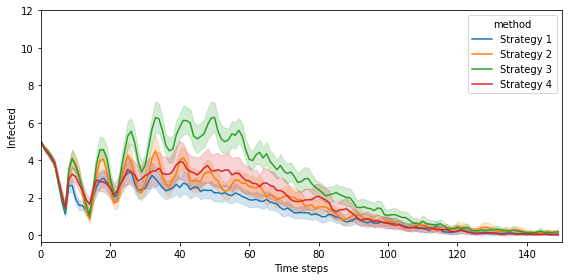

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 150)
plt.ylim(top = 12)
plt.tight_layout()

# Waxman's Model

In [ ]:
G_temp = nx.waxman_graph(500, 0.36, 0.06)#, metric=dist)
[G_temp.add_edge(i, random.randint(0,499)) for i in list(nx.isolates(G_temp))]
G = nx.convert_node_labels_to_integers(G_temp)

print("# of nodes: ", G.number_of_nodes())
print("Average degree: ", 2*G.number_of_edges()/G.number_of_nodes())
print(list(nx.isolates(G)))

# of nodes:  500
Average degree:  5.844
[]


In [ ]:
def network_gen():
  G_temp = nx.waxman_graph(500, 0.36, 0.06)#, metric=dist)
  [G_temp.add_edge(i, random.randint(0,499)) for i in list(nx.isolates(G_temp))]
  G = nx.convert_node_labels_to_integers(G_temp)
  return G

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##Testing Strategy _0

In [ ]:
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, avg_node_degree=6, data_G = network_gen())
for i in range(steps):
    model.step()
print (time.time()-st)
#agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:30])


In [ ]:
print("max_outbreak_size: ", get_column_data(model).Infected.max())
print("number_of_uninfected:",get_column_data(model).Susceptible.min())

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _1

In [ ]:
#model set_up for strategy 1
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    ind = random.sample(range(1,pop+1), pop)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0

    if np.mod(pop, capacity) != 0:
        null_tail = [0] * (capacity - np.mod(pop, capacity))
        finish_flag = int(np.ceil(pop/capacity))
        ind.extend(null_tail)
        t_order = np.array(ind).reshape(finish_flag, capacity)
    else:
      finish_flag = int(pop/capacity)
      t_order = np.array(ind).reshape(finish_flag, capacity)
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            if test_key < finish_flag:
                temp = model.datacollector.get_agent_vars_dataframe()
                temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
                infection_matrix = csr_matrix(temp.values)
                for v in t_order[test_key]:
                    if v == 0:
                        test_key = 0
                        break
                    n_tests += 1
                    if infection_matrix[v-1, i] == 2:
                        model.schedule.agents[v-1].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v,i))) 
                    if infection_matrix[v-1, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v-1].exposed_time) > 4:
                            model.schedule.agents[v-1].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v,i)))
                test_key += 1
                if test_key == finish_flag:
                    test_key = 0
                
            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()

    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_1 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _2

In [ ]:
#model set_up for strategy 2
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = random_groups(model.G, group_size)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0

      
    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_2 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _3

In [ ]:
#model set_up for strategy 3
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    random.shuffle(rand_groups)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_3 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _4

In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)
            else:
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_4 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

In [ ]:
group_df

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

##Testing Strategy_4_high_2


In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=500
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 75
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            else:
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)              
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_5 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

In [ ]:
group_df

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

##Vis

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_5['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_5])
temp = temp.reset_index()

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 150)
plt.ylim(top = 12)
plt.tight_layout()